# Load the Data
## Peeringdb

In [ ]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


# Caida AS Names

In [ ]:
import io
with open('../../preprocessing/data/caida/20251001.as-org2info.txt', 'r', newline='', encoding='utf-8') as input_file:
    lines = input_file.readlines()   
    # Buffers initialisieren
    aut_lines = []
    org_lines = []
    mode = None
    total_lines = len(lines)
    aut_count = 0
    org_count = 0 

    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith("# format:aut"):
            mode = "aut"
            continue
        elif line.startswith("# format:org_id"):
            mode = "org"
            continue
        elif line.startswith("#") or not line:
            # Andere Kommentar- oder Leerzeilen überspringen
            continue      
        if mode == "aut":
            aut_lines.append(line)
            aut_count += 1
        elif mode == "org":
            org_lines.append(line)
            org_count += 1
    # StringIO-Objekte aus den gesammelten Zeilen bauen
    aut_buffer = io.StringIO("\n".join(aut_lines))
    org_buffer = io.StringIO("\n".join(org_lines))
    # DataFrames einlesen
    aut_df = pd.read_csv(aut_buffer, sep="|",
                        names=["aut", "changed", "aut_name", "org_id", "opaque_id", "source"], usecols=["aut", "org_id", "source", "changed", "aut_name"])
    org_df = pd.read_csv(org_buffer, sep="|",
                        names=["org_id", "changed", "org_name", "country", "source"], usecols=["org_id", "org_name", "country"])

    # Join the DataFrames
    joined_df = pd.merge(aut_df, org_df, on="org_id", how="left")
joined_df.head()

,aut,changed,aut_name,org_id,source,org_name,country
0,1,20240618.0,LVLT-1,LPL-141-ARIN,ARIN,"Level 3 Parent, LLC",US
1,2,20231108.0,UDEL-DCN,UNIVER-19-Z-ARIN,ARIN,University of Delaware,US
2,3,20100927.0,MIT-GATEWAYS,MIT-2-ARIN,ARIN,Massachusetts Institute of Technology,US
3,4,20230929.0,ISI-AS,USC-32-Z-ARIN,ARIN,University of Southern California,US
4,5,20200723.0,SYMBOLICS,WGL-117-ARIN,ARIN,WFA Group LLC,US


## Join both

In [ ]:
peering_df_joined = pd.merge(net_df, joined_df, left_on='asn', right_on='aut', how='left')
peering_df_joined = peering_df_joined[['asn', 'org_name', 'country', 'source', 'info_type', "aut_name"]]
peering_df_joined.head()

,asn,org_name,country,source,info_type,aut_name
0,4436,"GTT Americas, LLC",US,ARIN,NSP,AS-GTT-4436
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1
2,31800,DALnet,US,ARIN,Non-Profit,DALNET
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,SWISSCOM
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,ASN-CXA-ALL-CCI-22773-RDC


# Classification

## TF-IDF

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ==== Daten vorbereiten ====
df = peering_df_joined.copy()
df["org_name"] = df["org_name"].fillna("unknown").str.lower()
df["aut_name"] = df["aut_name"].fillna("unknown").str.lower()

# Kleine Klassen raus (optional)
valid = df["info_type"].value_counts()
df = df[df["info_type"].isin(valid[valid >= 5].index)]

# ==== Train/Test-Split ====
X_train, X_test, y_train, y_test = train_test_split(
    df[["org_name", "aut_name"]], df["info_type"],
    test_size=0.13, random_state=42, stratify=df["info_type"]
)

# ==== Zwei getrennte TF-IDF Vectorizer ====
tfidf_org = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 6),
    lowercase=True, min_df=1, sublinear_tf=True
)

tfidf_aut = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 6),
    lowercase=True, min_df=1, sublinear_tf=True
)

# ColumnTransformer kombiniert sie parallel
vectorizer = ColumnTransformer(
    transformers=[
        ("org_tfidf", tfidf_org, "org_name"),
        ("aut_tfidf", tfidf_aut, "aut_name")
    ],
    remainder="drop"  # andere Spalten ignorieren
)

# ==== SVM + Kalibrierung ====
svm = LinearSVC(C=0.35, class_weight="balanced")
svm_cal = CalibratedClassifierCV(svm, method="sigmoid", cv=3)

svm_pipe = Pipeline([
    ("tfidf", vectorizer),
    ("svm_cal", svm_cal)
])

# ==== Train ====
svm_pipe.fit(X_train, y_train)

# ==== Test ====
y_pred_svm = svm_pipe.predict(X_test)

print("\n=== SVM (calibrated, 2x TF-IDF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Macro-F1:", f1_score(y_test, y_pred_svm, average="macro"))
print(classification_report(y_test, y_pred_svm))



=== SVM (calibrated, 2x TF-IDF) ===
Accuracy: 0.5973307291666666
Macro-F1: 0.45730904840817904
                    precision    recall  f1-score   support

            Access       0.64      0.91      0.75      1532
           Content       0.43      0.33      0.37       323
Education/Research       0.67      0.51      0.58       189
        Enterprise       0.44      0.24      0.31       320
  Network Services       0.73      0.38      0.50       190
           Transit       0.40      0.17      0.23       518

          accuracy                           0.60      3072
         macro avg       0.55      0.42      0.46      3072
      weighted avg       0.56      0.60      0.55      3072



## Bert

In [ ]:
# === Ersatz für den HF-Datasets-Teil (kein pyarrow/datasets nötig) ===
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer,
                          EarlyStoppingCallback, TextClassificationPipeline)

# --------- Konfig ---------
MODEL_NAME   = "xlm-roberta-base"   # multilingual, starkes Baseline-Modell
MAX_LENGTH   = 64                   # Org-Namen sind kurz -> 64 reicht
LR           = 1e-5
EPOCHS       = 20
BATCH_SIZE   = 32
WARMUP_RATIO = 0.06
SEED         = 42
OUT_DIR      = "xlmr_org_trainer_out"

tok = AutoTokenizer.from_pretrained(MODEL_NAME, sep_token='</s>')
le = LabelEncoder()

le = LabelEncoder()
df = peering_df_joined
df["label_id"] = le.fit_transform(df["info_type"])
num_labels = len(le.classes_)
print(f"Labels: {num_labels} Klassen ->", list(le.classes_))

df["label_id"] = le.fit_transform(df["info_type"])
df["org_name"] = df["org_name"].fillna("Unknown")
df["aut_name"] = df["aut_name"].fillna("Unknown")
SEP = tok.sep_token or "</s>"
df["text"] = df["org_name"] + f" {SEP} " + df["aut_name"]

df.fillna('Unknown', inplace=True)

# Prüfe GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU-Name: {torch.cuda.get_device_name(0)}")
else:
    print("Warnung: Keine GPU verfügbar, CPU wird verwendet.")

# Train/Validation Split (stratifiziert)
train_df, eval_df = train_test_split(
    df[["text", "label_id"]],
    test_size=0.13,
    random_state=SEED,
    stratify=df["label_id"]
)
train_df = train_df.reset_index(drop=True)
eval_df  = eval_df.reset_index(drop=True)

# Texte & Labels aus den bereits vorbereiteten DataFrames (train_df, eval_df)
train_texts = train_df["text"].tolist()
eval_texts  = eval_df["text"].tolist()
y_train_np  = train_df["label_id"].to_numpy()
y_eval_np   = eval_df["label_id"].to_numpy()
num_labels  = df["label_id"].nunique()



# Tokenisierung OHNE Padding (Padding macht später der DataCollator)
train_enc = tok(train_texts, truncation=True, max_length=MAX_LENGTH)
eval_enc  = tok(eval_texts,  truncation=True, max_length=MAX_LENGTH)

class SimpleHFLikeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

ds_train = SimpleHFLikeDataset(train_enc, y_train_np)
ds_eval  = SimpleHFLikeDataset(eval_enc,  y_eval_np)

collator = DataCollatorWithPadding(tokenizer=tok)

valid_classes = sorted(df["info_type"].unique())

# ---- Modell + Class Weights wie gehabt ----
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label={int(i): c for i, c in enumerate(valid_classes)},
    label2id={c: int(i) for i, c in enumerate(valid_classes)}
).to(device)

# Class-Weights aus dem Trainingssplit
class_counts = np.bincount(y_train_np, minlength=num_labels)
weights = class_counts.sum() / np.maximum(class_counts, 1)
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float, device=device)
print("Class weights:", np.round(weights, 3))


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # <- **kwargs!
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        # ModelOutput kann dict-ähnlich oder Attribute sein:
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs.logits

        # class_weights sicher auf dasselbe Device wie logits legen:
        cw = class_weights.to(logits.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    def compute_metrics(eval_pred):
    # eval_pred ist i.d.R. EvalPrediction
        try:
            preds = eval_pred.predictions
            labels = eval_pred.label_ids
        except Exception:
            preds, labels = eval_pred  # Fallback

        # Bei manchen Modellen kommt predictions als Tuple (logits, ...)
        if isinstance(preds, (tuple, list)):
            preds = preds[0]

        y_pred = np.argmax(preds, axis=-1)
        return {
            "accuracy":  float(accuracy_score(labels, y_pred)),
            "f1_macro":  float(f1_score(labels, y_pred, average="macro")),
            "precision": float(precision_score(labels, y_pred, average="macro", zero_division=0)),
            "recall":    float(recall_score(labels, y_pred, average="macro")),
        }

args = TrainingArguments(
    output_dir=OUT_DIR + "/checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    warmup_ratio=WARMUP_RATIO,
    fp16=(device.type=="cuda"),
    weight_decay=0.01,
    logging_steps=50,
    seed=SEED,
    report_to=["none"],
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    return {
        "accuracy":  float(accuracy_score(labels, preds)),
        "f1_macro":  float(f1_score(labels, preds, average="macro")),
        "precision": float(precision_score(labels, preds, average="macro", zero_division=0)),
        "recall":    float(recall_score(labels, preds, average="macro")),
    }

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
metrics = trainer.evaluate()
print("Eval:", metrics)

trainer.save_model(OUT_DIR + "/model")
tok.save_pretrained(OUT_DIR + "/model")


Labels: 6 Klassen -> ['Access', 'Content', 'Education/Research', 'Enterprise', 'Network Services', 'Transit']
Device: cuda
GPU-Name: NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_441881/1270387565.py:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Class weights: [0.202 0.959 1.636 0.969 1.636 0.599]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,1.766900,1.587671,0.398112,0.261572,0.301190,0.363307
2,1.476800,1.375982,0.541992,0.441902,0.433173,0.467665
3,1.416400,1.320157,0.508789,0.455588,0.454358,0.498953
4,1.330300,1.290994,0.542318,0.471763,0.467091,0.507352
5,1.299900,1.287330,0.497396,0.453958,0.439827,0.505874
6,1.246600,1.315441,0.531250,0.470021,0.464033,0.503551


Eval: {'eval_loss': 1.2909942865371704, 'eval_accuracy': 0.5423177083333334, 'eval_f1_macro': 0.471763318052624, 'eval_precision': 0.4670908374749681, 'eval_recall': 0.50735236297303, 'eval_runtime': 2.1363, 'eval_samples_per_second': 1438.028, 'eval_steps_per_second': 14.979, 'epoch': 6.0}


('xlmr_org_trainer_out/model/tokenizer_config.json',
 'xlmr_org_trainer_out/model/special_tokens_map.json',
 'xlmr_org_trainer_out/model/tokenizer.json')

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy import sparse
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# === 0) Train/Test Split ===================================
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    eval_df["org_name"].tolist(),
    y_eval_np,
    test_size=0.2,               # 20% für Test
    stratify=y_eval_np,          # gleiche Klassenverteilung
    random_state=42
)

print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

# === 1) TF-IDF =============================================
tfidf = TfidfVectorizer(
    analyzer="char_wb", ngram_range=(3, 6),
    sublinear_tf=True, strip_accents="unicode", lowercase=True
)
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_test_tfidf  = tfidf.transform(X_test_texts)

# === 2) XLM-R Embeddings ====================================
@torch.no_grad()
def xlmr_embed(texts, batch_size=64, max_length=256, pool="mean"):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        # Nur den Encoder-Body benutzen
        out = model.roberta(**{k: enc[k] for k in ("input_ids","attention_mask")})
        hidden = out.last_hidden_state  # [B, T, H]
        mask = enc["attention_mask"].unsqueeze(-1)
        if pool == "mean":
            summed = (hidden * mask).sum(1)
            counts = mask.sum(1).clamp(min=1)
            emb = summed / counts
        else:
            emb = hidden[:, 0, :]  # CLS
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        all_embs.append(emb.cpu().numpy())
    return np.vstack(all_embs)

# Train-Embeddings fitten
X_train_dense = xlmr_embed(X_train_texts, batch_size=64, max_length=256)
# Test-Embeddings nur transformieren
X_test_dense  = xlmr_embed(X_test_texts,  batch_size=64, max_length=256)

# === 3) Skalierung & Fusion ================================
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_dense_scaled = scaler.fit_transform(X_train_dense)
X_test_dense_scaled  = scaler.transform(X_test_dense)

# In sparse umwandeln und zusammenfügen
X_train_dense_sparse = sparse.csr_matrix(X_train_dense_scaled)
X_test_dense_sparse  = sparse.csr_matrix(X_test_dense_scaled)

X_train_fused = sparse.hstack([X_train_tfidf, X_train_dense_sparse], format="csr")
X_test_fused  = sparse.hstack([X_test_tfidf,  X_test_dense_sparse],  format="csr")

# === 4) Modell trainieren ==================================
clf = LogisticRegression(
    solver="saga",
    max_iter=5000,
    class_weight="balanced",
    penalty="elasticnet",
    l1_ratio=0.2,
    n_jobs=-1,
)

clf.fit(X_train_fused, y_train)

# === 5) Evaluation ==========================================
y_pred = clf.predict(X_test_fused)
print("\n=== Ergebnisse auf Test-Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\n", classification_report(y_test, y_pred, target_names=list(valid_classes)))

# === 6) Inferenzfunktion ===================================
def ensemble_predict_early(texts, batch_size=64):
    X_tfidf_new = tfidf.transform(texts)
    X_dense_new = xlmr_embed(texts, batch_size=batch_size)
    X_dense_scaled_new = scaler.transform(X_dense_new)
    X_new = sparse.hstack([X_tfidf_new, sparse.csr_matrix(X_dense_scaled_new)], format="csr")
    probs = clf.predict_proba(X_new)
    preds = probs.argmax(axis=1)
    return preds, probs

# Beispiel:
# preds, probs = ensemble_predict_early(["Google LLC", "Universität Bonn"])


KeyError: 'org_name'

In [ ]:
# ==== Ensemble aus kalibrierter SVM + XLM-R (Late Fusion) ====
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) Hilfsfunktionen: Probas holen und Klassenreihenfolge erzwingen
label_names = list(valid_classes)  # <- gleiche Reihenfolge wie beim HF-Modell (id2label/label2id)
label_index = {lbl: i for i, lbl in enumerate(label_names)}

def svm_proba(texts):
    """Kalibrierte SVM-Probas in label_names-Reihenfolge."""
    # svm_pipe.classes_ enthält die Klassenreihenfolge des SVM-Teils
    svm_labels = list(svm_pipe.named_steps["svm_cal"].classes_) if hasattr(svm_pipe.named_steps["svm_cal"], "classes_") \
                 else list(svm_pipe.classes_)
    proba = svm_pipe.predict_proba(texts)  # shape: [N, n_classes_svm]
    # Auf label_names umsortieren
    idx_map = [svm_labels.index(lbl) for lbl in label_names]
    proba_sorted = proba[:, idx_map]
    return proba_sorted

@torch.no_grad()
def xlmr_proba(texts, batch_size=64, max_length=256):
    """Transformer-Softmax-Probas in label_names-Reihenfolge (id2label stimmt auf valid_classes)."""
    model.eval()
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, max_length=max_length, padding=True, return_tensors="pt")
        enc = {k: v.to(model.device) for k, v in enc.items()}
        logits = model(**enc).logits  # [B, num_labels]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)  # [N, num_labels] schon in label_names-Reihenfolge

# 2) Probas auf deinem (Ensemble-)Validierungs/Testsplit erzeugen
X_eval = eval_df["org_name"].tolist()
y_eval = y_eval_np  # ints passend zur Reihenfolge in label_names

P_svm  = svm_proba(X_eval)              # [N, C]
P_xlmr = xlmr_proba(X_eval, max_length=MAX_LENGTH)  # [N, C]

# 3) Gewicht per einfacher Grid-Search finden (0..1)
grid = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, ..., 1.00
best = {"w": None, "f1": -1.0, "acc": 0.0}

for w in grid:
    P_ens = w * P_svm + (1.0 - w) * P_xlmr
    y_hat = P_ens.argmax(axis=1)
    f1 = f1_score(y_eval, y_hat, average="macro")
    acc = accuracy_score(y_eval, y_hat)
    if f1 > best["f1"] or (f1 == best["f1"] and acc > best["acc"]):
        best.update({"w": float(w), "f1": float(f1), "acc": float(acc)})

print(f"\n=== Ensemble-Gewichtssuche ===")
print(f"Bestes w (SVM-Anteil): {best['w']:.2f} | Macro-F1: {best['f1']:.4f} | Acc: {best['acc']:.4f}")

# 4) Finale Ensemble-Vorhersage + Report
w = best["w"]
P_ens = w * P_svm + (1.0 - w) * P_xlmr
y_pred = P_ens.argmax(axis=1)

print("\n=== Ensemble (SVM^w + XLM-R^(1-w)) auf Eval ===")
print("Accuracy:", accuracy_score(y_eval, y_pred))
print("Macro-F1:", f1_score(y_eval, y_pred, average="macro"))
print(classification_report(y_eval, y_pred, target_names=label_names))

# 5) Praktische Inferenzfunktion fürs spätere Nutzen
def ensemble_predict(texts, return_proba=False, batch_size=64):
    Ps = svm_proba(texts)
    Pt = xlmr_proba(texts, batch_size=batch_size, max_length=MAX_LENGTH)
    P = w * Ps + (1.0 - w) * Pt
    preds = P.argmax(axis=1)
    if return_proba:
        return preds, P
    return preds

# Beispiel:
# preds, proba = ensemble_predict(["google llc", "university of oxford"], return_proba=True)


KeyError: 'org_name'

In [ ]:
# ============================================================
# OOF-Stacking: SVM(TF-IDF) + XLM-R  → Meta-LogReg
# - Sauberer Train/Test-Split
# - OOF-Predictions nur auf Train (kein Leakage)
# - Meta-Klassifikator lernt, wann welchem Modell zu trauen ist
# ============================================================

import numpy as np
import torch
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# ====== 0) Grundeinstellungen ===============================================

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# Daten + Labelnamen (aus deinem Kontext)
texts_all: List[str] = eval_df["org_name"].tolist()
labels_all: np.ndarray = y_eval_np  # ints 0..5
label_names: List[str] = list(valid_classes)  # ['Access', 'Content', ..., 'Transit']
num_classes = len(label_names)
random_state = 42

# ====== 1) Train/Test-Split (Holdout bleibt unberührt) ======================

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts_all, labels_all, test_size=0.2, stratify=labels_all, random_state=random_state
)

print(f"Train: {len(X_train_texts)} | Test: {len(X_test_texts)} | Classes: {num_classes}")

# ====== 2) Basismodelle =====================================================

# 2a) SVM-Pipeline (TF-IDF + LinearSVC + Kalibrierung)
def build_svm_pipeline():
    tfidf = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(2, 7),          # etwas breiter als 3-6, erfahrungsgemäß besser für Org-Namen
        lowercase=True,
        sublinear_tf=True,
        strip_accents="unicode",
        min_df=2                      # minimiert Overfit auf rare n-Gramme; bei kleinem Datensatz ggf. 1
    )
    base = LinearSVC(class_weight="balanced", random_state=random_state)
    svm_cal = CalibratedClassifierCV(base, cv=5, method="sigmoid")  # gute, stabile Kalibrierung
    pipe = Pipeline([
        ("tfidf", tfidf),
        ("svm_cal", svm_cal)
    ])
    return pipe

# 2b) XLM-R → Wahrscheinlichkeiten
@torch.no_grad()
def xlmr_proba(texts: List[str], batch_size=64, max_length=256) -> np.ndarray:
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="XLM-R proba"):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits  # [B, C]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)  # [N, C]

# Hilfsfunktion: SVM-Probas auf label_names-Reihenfolge mappen
def map_proba_to_label_order(pipe: Pipeline, proba: np.ndarray, target_order: List[str]) -> np.ndarray:
    if "svm_cal" in pipe.named_steps:
        classes = list(pipe.named_steps["svm_cal"].classes_)
    else:
        classes = list(pipe.classes_)
    # Klassen sind Integers 0..C-1; sicherstellen, dass Reihenfolge stimmt.
    # Wenn deine Labels Integers 0..C-1 sind und pipe-classes dieselbe Ordnung haben,
    # ist das schon korrekt. Aus Sicherheitsgründen sortieren wir nach target_order-Index:
    # (hier entspricht label_names-Order der Integer-Order; deshalb ist das idempotent)
    idx_map = [classes.index(i) for i in range(num_classes)]
    return proba[:, idx_map]

# ====== 3) OOF-Predictions auf dem TRAIN-Teil (kein Leakage) ================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

oof_svm = np.zeros((len(X_train_texts), num_classes), dtype=np.float32)
oof_xlm = np.zeros((len(X_train_texts), num_classes), dtype=np.float32)

svm_pipes_per_fold = []  # zum späteren Refit (optional)
for fold, (tr, va) in enumerate(skf.split(np.zeros(len(y_train)), y_train), 1):
    X_tr = [X_train_texts[i] for i in tr]
    y_tr = y_train[tr]
    X_va = [X_train_texts[i] for i in va]

    # SVM fit auf Fold-Train → Probas auf Fold-Val
    svm_pipe = build_svm_pipeline()
    svm_pipe.fit(X_tr, y_tr)
    P_svm_va = svm_pipe.predict_proba(X_va)  # [N_va, C]
    P_svm_va = map_proba_to_label_order(svm_pipe, P_svm_va, label_names)
    oof_svm[va] = P_svm_va
    svm_pipes_per_fold.append(svm_pipe)

    # XLM-R Probas auf Fold-Val (XLM-R wird hier nicht weiter gefittet)
    P_xlm_va = xlmr_proba(X_va, batch_size=64, max_length=256)
    oof_xlm[va] = P_xlm_va

# Sanity-Check: keine Nullzeilen
assert np.all(oof_svm.sum(axis=1) > 0), "OOF SVM enthält leere Zeilen!"
assert np.all(oof_xlm.sum(axis=1) > 0), "OOF XLM enthält leere Zeilen!"

# ====== 4) Meta-Features & Meta-Classifier =================================

meta_X_train = np.hstack([oof_svm, oof_xlm])  # [N_train, 2*C]
meta_y_train = y_train

meta = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    random_state=random_state
)
meta.fit(meta_X_train, meta_y_train)

# ====== 5) Finales Training der Basismodelle auf dem KOMPLETTEN Train =======

svm_full = build_svm_pipeline()
svm_full.fit(X_train_texts, y_train)
P_svm_test = svm_full.predict_proba(X_test_texts)
P_svm_test = map_proba_to_label_order(svm_full, P_svm_test, label_names)

P_xlm_test = xlmr_proba(X_test_texts, batch_size=64, max_length=256)

meta_X_test = np.hstack([P_svm_test, P_xlm_test])  # [N_test, 2*C]
y_pred = meta.predict(meta_X_test)

# ====== 6) Evaluation auf echtem Test-Set ===================================

print("\n=== OOF-Stacking: Ergebnisse auf Test-Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\n", classification_report(y_test, y_pred, target_names=label_names))

# ====== 7) Inferenzfunktion (für neuen Text) ================================

def ensemble_predict_stacked(texts: List[str], batch_size=64):
    """
    Gibt (preds, probs) zurück.
    - Basismodelle: svm_full (TF-IDF+LinearSVC+Calib) & XLM-R
    - Meta: multinomiale LogReg auf [P_svm, P_xlm]
    """
    P_svm = svm_full.predict_proba(texts)
    P_svm = map_proba_to_label_order(svm_full, P_svm, label_names)
    P_xlm = xlmr_proba(texts, batch_size=batch_size, max_length=256)
    meta_X = np.hstack([P_svm, P_xlm])
    P_meta = meta.predict_proba(meta_X)
    preds = P_meta.argmax(axis=1)
    return preds, P_meta

# Beispiel:
# preds, probs = ensemble_predict_stacked(["Google LLC", "Universität Bonn"])
# print(preds)


Train: 2457 | Test: 615 | Classes: 6


XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 83.07it/s]



XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 84.44it/s]

XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 83.65it/s]

XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 88.67it/s]

XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 85.57it/s]
/home/jhart/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(

/home/jhart/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
XLM-R proba: 100%|██████████| 10/10 [00:00<00:00, 85.05it/s]


=== OOF-Stacking: Ergebnisse auf Test-Set ===
Accuracy: 0.4975609756097561
Macro-F1: 0.43867501117205493

                     precision    recall  f1-score   support

            Access       0.75      0.62      0.68       307
           Content       0.32      0.45      0.37        64
Education/Research       0.68      0.68      0.68        38
        Enterprise       0.27      0.33      0.30        64
  Network Services       0.34      0.39      0.37        38
           Transit       0.23      0.24      0.23       104

          accuracy                           0.50       615
         macro avg       0.43      0.45      0.44       615
      weighted avg       0.54      0.50      0.51       615



In [ ]:
# ============================================================
# Klassen-gewichtetetes Ensembling (per-class weights)
# SVM(TF-IDF, kalibriert) + XLM-R → w_c pro Klasse auf OOF optimiert
# ============================================================

import numpy as np
import torch
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score

# === Setup / Daten ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

texts_all: List[str] = eval_df["org_name"].tolist()
labels_all: np.ndarray = y_eval_np  # ints 0..5
label_names: List[str] = list(valid_classes)
C = len(label_names)
rng = 42

# === Train/Test Split (Holdout) ===
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts_all, labels_all, test_size=0.2, stratify=labels_all, random_state=rng
)
print(f"Train: {len(X_train_texts)} | Test: {len(X_test_texts)} | Classes: {C}")

# === Basismodell 1: TF-IDF + LinearSVC (kalibriert) ===
def build_svm_pipeline():
    tfidf = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(2, 7),
        lowercase=True,
        sublinear_tf=True,
        strip_accents="unicode",
        min_df=2
    )
    base = LinearSVC(class_weight="balanced", random_state=rng)
    svm_cal = CalibratedClassifierCV(base, cv=5, method="sigmoid")
    return Pipeline([("tfidf", tfidf), ("svm_cal", svm_cal)])

# === Basismodell 2: XLM-R → Softmax-Probas ===
@torch.no_grad()
def xlmr_proba(texts: List[str], batch_size=64, max_length=256) -> np.ndarray:
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="XLM-R proba"):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits  # [B, C]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)

def map_proba_to_label_order(pipe: Pipeline, proba: np.ndarray) -> np.ndarray:
    classes = list(pipe.named_steps["svm_cal"].classes_)
    # falls Klassen 0..C-1 sind, ist das idempotent; ansonsten in integer Reihenfolge sortieren:
    idx_map = [classes.index(i) for i in range(C)]
    return proba[:, idx_map]

# === OOF-Predictions auf TRAIN (kein Leakage) ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
oof_svm = np.zeros((len(y_train), C), dtype=np.float32)
oof_xlm = np.zeros((len(y_train), C), dtype=np.float32)

for fold, (tr, va) in enumerate(skf.split(np.zeros(len(y_train)), y_train), 1):
    X_tr = [X_train_texts[i] for i in tr]
    y_tr = y_train[tr]
    X_va = [X_train_texts[i] for i in va]

    svm_pipe = build_svm_pipeline()
    svm_pipe.fit(X_tr, y_tr)
    P_svm_va = svm_pipe.predict_proba(X_va)
    oof_svm[va] = map_proba_to_label_order(svm_pipe, P_svm_va)

    P_xlm_va = xlmr_proba(X_va, batch_size=64, max_length=256)
    oof_xlm[va] = P_xlm_va

# === per-class Gewicht-Optimierung auf OOF ===
def macro_f1_from_mix(Pa, Pb, y_true, w_vec):
    # Pa, Pb: [N, C], w_vec: [C] → P = w_c*Pa + (1-w_c)*Pb
    P = Pa * w_vec + Pb * (1.0 - w_vec)
    y_hat = P.argmax(axis=1)
    return f1_score(y_true, y_hat, average="macro")

# Koordinatensuche: iteriere über Klassen, suche bestes w_c auf einem kleinen Grid
w = np.full(C, 0.5, dtype=np.float32)
grid = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, ..., 1.00

best_macro = macro_f1_from_mix(oof_svm, oof_xlm, y_train, w)
improved = True
max_outer_loops = 5

for _ in range(max_outer_loops):
    if not improved:
        break
    improved = False
    for c in range(C):
        best_wc = w[c]
        best_score_c = best_macro
        for wc in grid:
            w_try = w.copy()
            w_try[c] = wc
            s = macro_f1_from_mix(oof_svm, oof_xlm, y_train, w_try)
            if s > best_score_c:
                best_score_c = s
                best_wc = wc
        if best_wc != w[c]:
            w[c] = best_wc
            best_macro = best_score_c
            improved = True

print("\n=== Klassen-Gewichte (SVM-Anteil) ===")
for name, wc in zip(label_names, w):
    print(f"{name:>20s}: w_c = {wc:.2f}")
print(f"Macro-F1 (OOF, mit w_c): {best_macro:.4f}")

# === Final: Basismodelle auf vollem Train fitten → Test-Probas ===
svm_full = build_svm_pipeline()
svm_full.fit(X_train_texts, y_train)
P_svm_test = map_proba_to_label_order(svm_full, svm_full.predict_proba(X_test_texts))
P_xlm_test = xlmr_proba(X_test_texts, batch_size=64, max_length=256)

# Mix mit per-class Gewichten
P_test = P_svm_test * w + P_xlm_test * (1.0 - w)  # broadcast über Klassenachse
y_pred = P_test.argmax(axis=1)

print("\n=== Klassen-gewichtetes Ensemble: Test-Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
from sklearn.metrics import classification_report
print("\n", classification_report(y_test, y_pred, target_names=label_names))


KeyError: 'org_name'

In [ ]:
# ============================================================
# Reusable sklearn Estimator: Per-class weighted late fusion
# - OOF-basiertes Lernen der w_c
# - Basismodelle: TF-IDF + LinearSVC (kalibriert), XLM-R (Softmax)
# ============================================================

import numpy as np
import torch
from typing import List, Optional, Tuple
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

class PerClassWeightedLateFusion(BaseEstimator, ClassifierMixin):
    """
    sklearn-kompatibler Ensembler:
      - lernt per Klasse w_c (SVM-Anteil) via OOF-Probas (kein Leakage)
      - refittet SVM auf vollem Train
      - mischt SVM/XLM-R-Probas im Predict
    """

    def __init__(
        self,
        tokenizer,                       # HF Tokenizer (tok)
        hf_model,                        # HF SequenceClassification Model (feingetunt)
        n_splits: int = 5,
        grid_steps: int = 21,            # 0..1 in grid_steps Punkten
        max_outer_loops: int = 5,        # Koordinatensuche
        batch_size: int = 64,
        max_length: int = 256,
        rng: int = 42,
        tfidf_ngram_range: Tuple[int,int] = (2,7),
        tfidf_min_df: int = 2,
        temp_svm: Optional[float] = None,  # Temperature scaling für SVM-Probas (z.B. 1.2)
        temp_xlm: Optional[float] = None,  # Temperature scaling für XLM-R (z.B. 1.5)
    ):
        self.tokenizer = tokenizer
        self.hf_model = hf_model
        self.n_splits = n_splits
        self.grid_steps = grid_steps
        self.max_outer_loops = max_outer_loops
        self.batch_size = batch_size
        self.max_length = max_length
        self.rng = rng
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_min_df = tfidf_min_df
        self.temp_svm = temp_svm
        self.temp_xlm = temp_xlm

        # werden in fit() gesetzt
        self.C_: Optional[int] = None
        self.classes_: Optional[np.ndarray] = None
        self.w_: Optional[np.ndarray] = None            # (C,)
        self.svm_full_: Optional[Pipeline] = None       # TF-IDF + Calibrated LinearSVC

        # HF Gerät
        self.device_ = "cuda" if torch.cuda.is_available() else "cpu"
        self.hf_model.eval().to(self.device_)

    # ---------- Hilfsblöcke ----------
    def _build_svm_pipeline(self) -> Pipeline:
        tfidf = TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=self.tfidf_ngram_range,
            lowercase=True,
            sublinear_tf=True,
            strip_accents="unicode",
            min_df=self.tfidf_min_df,
        )
        base = LinearSVC(class_weight="balanced", random_state=self.rng)
        svm_cal = CalibratedClassifierCV(base, cv=5, method="sigmoid")
        return Pipeline([("tfidf", tfidf), ("svm_cal", svm_cal)])

    @torch.no_grad()
    def _xlmr_proba(self, texts: List[str]) -> np.ndarray:
        probs_all = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i+self.batch_size]
            enc = self.tokenizer(batch, truncation=True, padding=True,
                                 max_length=self.max_length, return_tensors="pt")
            enc = {k: v.to(self.device_) for k, v in enc.items()}
            logits = self.hf_model(**enc).logits
            probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
            probs_all.append(probs)
        P = np.vstack(probs_all)
        if self.temp_xlm is not None:
            P = self._temp_scale(P, self.temp_xlm)
        return P

    @staticmethod
    def _temp_scale(P: np.ndarray, T: float) -> np.ndarray:
        # Temperatur-Skalierung in der Proba-Domäne (logit-approx)
        logits = np.log(np.clip(P, 1e-8, 1 - 1e-8))
        logits /= T
        E = np.exp(logits)
        return E / E.sum(axis=1, keepdims=True)

    @staticmethod
    def _macro_f1_from_mix(Pa, Pb, y_true, w_vec) -> float:
        P = Pa * w_vec + Pb * (1.0 - w_vec)  # Broadcasting (N,C) * (C,)
        y_hat = P.argmax(axis=1)
        # eigene F1-Implementierung vermeiden → Import lokal:
        from sklearn.metrics import f1_score
        return f1_score(y_true, y_hat, average="macro")

    def _map_proba_svm(self, pipe: Pipeline, proba: np.ndarray) -> np.ndarray:
        # SVM-Klassen sind i.d.R. ints 0..C-1; ordnen robust nach self.classes_
        if "svm_cal" in pipe.named_steps:
            classes = list(pipe.named_steps["svm_cal"].classes_)
        else:
            classes = list(pipe.classes_)
        idx_map = [classes.index(int(c)) for c in self.classes_]
        P = proba[:, idx_map]
        if self.temp_svm is not None:
            P = self._temp_scale(P, self.temp_svm)
        return P

    # ---------- sklearn API ----------
    def fit(self, X: List[str], y: np.ndarray):
        """
        Lernt w_c auf OOF, refittet SVM auf full Train.
        X: Liste von Texten
        y: np.array ints (0..C-1)
        """
        X = list(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.C_ = len(self.classes_)

        # OOF-Predictions
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.rng)
        oof_svm = np.zeros((len(y), self.C_), dtype=np.float32)
        oof_xlm = np.zeros((len(y), self.C_), dtype=np.float32)

        for tr, va in skf.split(np.zeros(len(y)), y):
            X_tr = [X[i] for i in tr]; y_tr = y[tr]
            X_va = [X[i] for i in va]

            svm_pipe = self._build_svm_pipeline()
            svm_pipe.fit(X_tr, y_tr)
            P_svm_va = svm_pipe.predict_proba(X_va)
            oof_svm[va] = self._map_proba_svm(svm_pipe, P_svm_va)

            oof_xlm[va] = self._xlmr_proba(X_va)

        # Koordinaten-Suche für w_c
        w = np.full(self.C_, 0.5, dtype=np.float32)
        grid = np.linspace(0.0, 1.0, self.grid_steps)
        best_macro = self._macro_f1_from_mix(oof_svm, oof_xlm, y, w)
        for _ in range(self.max_outer_loops):
            improved = False
            for c in range(self.C_):
                best_wc = w[c]; best_c = best_macro
                for wc in grid:
                    w_try = w.copy(); w_try[c] = wc
                    s = self._macro_f1_from_mix(oof_svm, oof_xlm, y, w_try)
                    if s > best_c:
                        best_c = s; best_wc = wc
                if best_wc != w[c]:
                    w[c] = best_wc; best_macro = best_c; improved = True
            if not improved:
                break

        self.w_ = w

        # SVM auf vollem Train fitten
        self.svm_full_ = self._build_svm_pipeline()
        self.svm_full_.fit(X, y)
        return self

    def predict_proba(self, X: List[str]) -> np.ndarray:
        assert self.w_ is not None and self.svm_full_ is not None, "Call fit() first."
        Ps = self.svm_full_.predict_proba(X)
        Ps = self._map_proba_svm(self.svm_full_, Ps)
        Pt = self._xlmr_proba(X)
        # per-class Mischung
        return Ps * self.w_ + Pt * (1.0 - self.w_)

    def predict(self, X: List[str]) -> np.ndarray:
        P = self.predict_proba(X)
        return P.argmax(axis=1)

    # optional: zur Kompatibilität
    def get_params(self, deep=True):
        return {
            "tokenizer": self.tokenizer,
            "hf_model": self.hf_model,
            "n_splits": self.n_splits,
            "grid_steps": self.grid_steps,
            "max_outer_loops": self.max_outer_loops,
            "batch_size": self.batch_size,
            "max_length": self.max_length,
            "rng": self.rng,
            "tfidf_ngram_range": self.tfidf_ngram_range,
            "tfidf_min_df": self.tfidf_min_df,
            "temp_svm": self.temp_svm,
            "temp_xlm": self.temp_xlm,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Daten
X_all = eval_df["org_name"].tolist()
y_all = y_eval_np  # ints 0..C-1
label_names = list(valid_classes)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Instanz
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,    # optional: 1.1–1.3
    temp_xlm=None,    # optional: 1.3–1.6
)

# Train
ens.fit(X_tr, y_tr)

# Inspect Gewichte
print("w_c (SVM-Anteil):", ens.w_)

# Test
y_pred = ens.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names))

# Inferenz
preds = ens.predict(["Google LLC", "Universität Bonn"])
probs = ens.predict_proba(["Google LLC", "Universität Bonn"])
print("Preds:", preds)
print("Probs:", probs)


KeyError: 'org_name'

In [ ]:
as_rank_df = pd.read_csv('../../preprocessing/data/asrank/as_rank_df.csv')
as_rank_df.head()

,asn,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,3356,1,6613,6545,68,0,53986,873410,3468642119
1,1299,2,2567,2509,58,0,41193,776707,3219679484
2,174,3,6723,6626,97,0,38887,730166,3034352967
3,3257,4,1853,1816,37,0,36040,612491,2791999209
4,2914,5,1541,1483,58,0,25179,576134,2918763154


In [ ]:
peering_df_joined_with_asrank = pd.merge(
    peering_df_joined,
    as_rank_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank['rank'].fillna(peering_df_joined_with_asrank['rank'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_total'].fillna(peering_df_joined_with_asrank['asnDegree_total'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_customer'].fillna(peering_df_joined_with_asrank['asnDegree_customer'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_peer'].fillna(peering_df_joined_with_asrank['asnDegree_peer'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_provider'].fillna(peering_df_joined_with_asrank['asnDegree_provider'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberAsns'].fillna(peering_df_joined_with_asrank['cone_numberAsns'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberPrefixes'].fillna(peering_df_joined_with_asrank['cone_numberPrefixes'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberAddresses'].fillna(peering_df_joined_with_asrank['cone_numberAddresses'].median(), inplace=True)

peering_df_joined_with_asrank.head()

/tmp/ipykernel_441881/1286543727.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  peering_df_joined_with_asrank['rank'].fillna(peering_df_joined_with_asrank['rank'].median(), inplace=True)
/tmp/ipykernel_441881/1286543727.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

,asn,org_name,country,source,info_type,aut_name,label_id,text,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,4436,"GTT Americas, LLC",US,ARIN,Transit,AS-GTT-4436,5,"GTT Americas, LLC </s> AS-GTT-4436",78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1,1,Akamai International B.V. </s> AKAMAI-ASN1,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0
2,31800,DALnet,US,ARIN,Enterprise,DALNET,3,DALnet </s> DALNET,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Access,SWISSCOM,0,Swisscom (Schweiz) AG </s> SWISSCOM,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0
4,22773,Cox Communications Inc.,US,ARIN,Access,ASN-CXA-ALL-CCI-22773-RDC,0,Cox Communications Inc. </s> ASN-CXA-ALL-CCI-2...,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0


In [ ]:
ipinfo_df = pd.read_csv('../../preprocessing/data/ipinfo_domains/ipinfo_domains.csv')
ipinfo_df.head()

,ASN,domains
0,16509,139276485
1,13335,63477595
2,52925,32915972
3,396982,24543491
4,47846,17833760


In [ ]:
peering_df_joined_with_asrank_and_domains = pd.merge(
    peering_df_joined_with_asrank,
    ipinfo_df,
    left_on='asn',
    right_on='ASN',
    how='left'
)
peering_df_joined_with_asrank_and_domains['domains'].fillna(peering_df_joined_with_asrank_and_domains['domains'].median(), inplace=True)
peering_df_joined_with_asrank_and_domains.drop(columns=['ASN'], inplace=True)
peering_df_joined_with_asrank_and_domains.head()

/tmp/ipykernel_441881/4162325289.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  peering_df_joined_with_asrank_and_domains['domains'].fillna(peering_df_joined_with_asrank_and_domains['domains'].median(), inplace=True)


,asn,org_name,country,source,info_type,aut_name,label_id,text,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses,domains
0,4436,"GTT Americas, LLC",US,ARIN,Transit,AS-GTT-4436,5,"GTT Americas, LLC </s> AS-GTT-4436",78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.0
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1,1,Akamai International B.V. </s> AKAMAI-ASN1,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0,3849287.0
2,31800,DALnet,US,ARIN,Enterprise,DALNET,3,DALnet </s> DALNET,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0,21.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Access,SWISSCOM,0,Swisscom (Schweiz) AG </s> SWISSCOM,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0,46521.0
4,22773,Cox Communications Inc.,US,ARIN,Access,ASN-CXA-ALL-CCI-22773-RDC,0,Cox Communications Inc. </s> ASN-CXA-ALL-CCI-2...,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0,55711.0


In [ ]:
bgp_df = pd.read_csv('../../scripts/as_visibility.csv')

In [ ]:
bgp_joined = pd.merge(
    peering_df_joined_with_asrank_and_domains,
    bgp_df,
    on='asn',
    how='left'
)
bgp_joined['seen_peers_path'].fillna(bgp_joined['seen_peers_path'].median(), inplace=True)
bgp_joined['seen_peers_origin'].fillna(bgp_joined['seen_peers_origin'].median(), inplace=True)
bgp_joined['visibility_path'].fillna(bgp_joined['visibility_path'].median(), inplace=True)
bgp_joined['visibility_origin'].fillna(bgp_joined['visibility_origin'].median(), inplace=True)
bgp_joined['total_peers'].fillna(bgp_joined['total_peers'].median(), inplace=True)
bgp_joined.head()

/tmp/ipykernel_431807/766528583.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bgp_joined['seen_peers_path'].fillna(bgp_joined['seen_peers_path'].median(), inplace=True)
/tmp/ipykernel_431807/766528583.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

,asn,org_name,country,source,info_type,label_id,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,...,visibility_path,seen_peers_origin,visibility_origin,centrality_mean,endprox_mean,nonterminal_rate,path_occurrences,origin_occurrences,total_unique_paths,total_peers
0,4436,"GTT Americas, LLC",US,ARIN,Transit,5,78320.0,0.0,0.0,0.0,...,0.345133,0.0,0.000000,0.506838,0.253419,1.000000,39.0,0.0,7611576.0,113.0
1,20940,Akamai International B.V.,NL,RIPE,Content,1,1894.0,485.0,14.0,366.0,...,0.840708,94.0,0.831858,0.310215,0.155108,0.629129,25974.0,94.0,7611576.0,113.0
2,31800,DALnet,US,ARIN,Enterprise,3,47745.0,78.0,0.0,74.0,...,0.345133,47.0,0.415929,0.000000,0.000000,0.000000,39.0,47.0,7611576.0,113.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Access,0,81.0,1273.0,166.0,1101.0,...,0.743363,85.0,0.752212,0.791847,0.395923,0.993558,26546.0,85.0,7611576.0,113.0
4,22773,Cox Communications Inc.,US,ARIN,Access,0,110.0,499.0,489.0,8.0,...,0.716814,81.0,0.716814,0.573053,0.286527,0.988001,16251.0,81.0,7611576.0,113.0


In [ ]:
ch_df = pd.read_csv('../../preprocessing/data/clickhouse/asn_geolocation_stats.csv')

In [ ]:
peering_df_joined_with_asrank_and_domains_and_geoloc = pd.merge(
    bgp_joined,
    ch_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank_and_domains_and_geoloc['org_name'] = peering_df_joined_with_asrank_and_domains_and_geoloc['org_name'].fillna('unknown').str.lower()
peering_df_joined_with_asrank_and_domains_and_geoloc.columns.tolist()

['asn',
 'org_name',
 'country',
 'source',
 'info_type',
 'label_id',
 'rank',
 'asnDegree_total',
 'asnDegree_customer',
 'asnDegree_peer',
 'asnDegree_provider',
 'cone_numberAsns',
 'cone_numberPrefixes',
 'cone_numberAddresses',
 'domains',
 'seen_peers_path',
 'visibility_path',
 'seen_peers_origin',
 'visibility_origin',
 'centrality_mean',
 'endprox_mean',
 'nonterminal_rate',
 'path_occurrences',
 'origin_occurrences',
 'total_unique_paths',
 'total_peers',
 'center_lat',
 'center_lon',
 'total_weight',
 'unique_points',
 'country_count',
 'mean_km',
 'var_km2',
 'std_km',
 'iqr_km',
 'p25_km',
 'p50_km',
 'p75_km',
 'p90_km',
 'p95_km',
 'p99_km',
 'min_km',
 'max_km',
 'pct_ips_le_100km',
 'pct_ips_le_500km',
 'pct_ips_le_1000km',
 'country_entropy_bits',
 'country_entropy_norm']

In [ ]:
# ============================================================
# Neuer Train/Test-Split (ohne Re-Training deiner Modelle)
# - stratifiziert, reproduzierbar
# - speichert die Indizes
# - evaluiert bestehendes Ensemble (globales w) und optional numerische Features
# ============================================================

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ---- Daten vorbereiten ----
X_all = eval_df["org_name"].tolist()
y_all = y_eval_np  # ints 0..C-1
label_names = list(valid_classes)
C = len(label_names)
RANDOM_STATE = 12345  # NEUER Seed für neuen Split (änderbar)

# Optional: externe numerische Features (müssen 1:1 zu eval_df ausgerichtet sein)
# X_num_aligned = ...  # shape [N, D] oder None
use_num = 'X_num_aligned' in globals() and X_num_aligned is not None

# ---- Neuer stratifizierter Split ----
idx_all = np.arange(len(X_all))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=RANDOM_STATE
)

# Indizes speichern (für Reproduzierbarkeit)
np.save("split_train_idx.npy", idx_tr)
np.save("split_test_idx.npy", idx_te)

X_tr = [X_all[i] for i in idx_tr]
X_te = [X_all[i] for i in idx_te]
X_tr_num = X_num_aligned[idx_tr] if use_num else None
X_te_num = X_num_aligned[idx_te] if use_num else None

# ---- Hilfsfunktionen mit deinen bestehenden Modellen ----
def svm_proba(texts):
    if hasattr(svm_pipe.named_steps.get("svm_cal", None), "classes_"):
        svm_classes = list(svm_pipe.named_steps["svm_cal"].classes_)
    else:
        svm_classes = list(svm_pipe.classes_)
    proba = svm_pipe.predict_proba(texts)
    # mappe sicherheitshalber auf Klassen 0..C-1
    idx_map = [svm_classes.index(i) for i in range(len(svm_classes))]
    return proba[:, idx_map]

@torch.no_grad()
def xlmr_proba(texts, batch_size=64, max_length=256):
    model.eval()
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(model.device) for k, v in enc.items()}
        logits = model(**enc).logits
        out.append(torch.softmax(logits, dim=-1).detach().cpu().numpy())
    return np.vstack(out)

# Optional: einfache Temperatur-Skalierung (falls du willst)
def temp_scale(P, T=1.0):
    if T == 1.0: return P
    L = np.log(np.clip(P, 1e-8, 1-1e-8)); L /= T
    E = np.exp(L); return E / E.sum(1, keepdims=True)

TEMP_SVM = 1.0  # z.B. 1.1
TEMP_XLM = 1.0  # z.B. 1.5

# ---- Gewicht w AUF TRAIN bestimmen (kein Leakage) ----
P_svm_tr  = temp_scale(svm_proba(X_tr), T=TEMP_SVM)
P_xlmr_tr = temp_scale(xlmr_proba(X_tr, batch_size=64, max_length=MAX_LENGTH), T=TEMP_XLM)

grid = np.linspace(0.0, 1.0, 21)
best = {"w": 0.5, "f1": -1.0, "acc": 0.0}
for w in grid:
    P_mix = w*P_svm_tr + (1.0 - w)*P_xlmr_tr
    y_hat = P_mix.argmax(1)
    f1 = f1_score(y_tr, y_hat, average="macro")
    acc = accuracy_score(y_tr, y_hat)
    if f1 > best["f1"] or (f1 == best["f1"] and acc > best["acc"]):
        best.update({"w": float(w), "f1": float(f1), "acc": float(acc)})

print(f"\nNeuer Split (Seed={RANDOM_STATE}) – bestes w (Train): {best['w']:.2f} | F1m@Train: {best['f1']:.4f}")

# ---- Finale Bewertung AUF TEST (unberührt) ----
P_svm_te  = temp_scale(svm_proba(X_te), T=TEMP_SVM)
P_xlmr_te = temp_scale(xlmr_proba(X_te, batch_size=64, max_length=MAX_LENGTH), T=TEMP_XLM)

w = best["w"]
P_ens_te = w*P_svm_te + (1.0 - w)*P_xlmr_te
y_pred   = P_ens_te.argmax(1)

print("\n=== Late-Fusion (globales w) – TEST ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names))

# ---- Optional: numerische Features nur in der Meta-Ebene nutzen ----
# Wenn du deine externen Werte mitverwenden willst, empfehle ich das OOF-Stacking mit Numerics
# (Meta-LogReg), das wir schon gebaut haben. Du kannst einfach den neuen Split wiederverwenden:
# ens_num.fit(X_tr, y_tr, X_num=X_tr_num); ens_num.predict(X_te, X_num=X_te_num)


KeyError: 'org_name'

In [ ]:
# ============================================================
# Klassen-gewichtetes Ensembling (per-class w_c)
# Basierend auf deinem neuen Split (Seed=12345)
# ============================================================

import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score, classification_report

label_names = list(valid_classes)
C = len(label_names)

# ---- Train/Test-Split laden oder aus vorherigem Schritt übernehmen ----
# Wenn du die Indizes schon gespeichert hast:
idx_tr = np.load("split_train_idx.npy")
idx_te = np.load("split_test_idx.npy")

X_all = eval_df["org_name"].tolist()
y_all = y_eval_np

X_tr = [X_all[i] for i in idx_tr]
y_tr = y_all[idx_tr]
X_te = [X_all[i] for i in idx_te]
y_te = y_all[idx_te]

# ---- Proba-Funktionen (wie gehabt) ----
def svm_proba(texts):
    if hasattr(svm_pipe.named_steps.get("svm_cal", None), "classes_"):
        svm_classes = list(svm_pipe.named_steps["svm_cal"].classes_)
    else:
        svm_classes = list(svm_pipe.classes_)
    proba = svm_pipe.predict_proba(texts)
    idx_map = [svm_classes.index(i) for i in range(len(svm_classes))]
    return proba[:, idx_map]

@torch.no_grad()
def xlmr_proba(texts, batch_size=64, max_length=256):
    model.eval()
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(model.device) for k, v in enc.items()}
        logits = model(**enc).logits
        out.append(torch.softmax(logits, dim=-1).detach().cpu().numpy())
    return np.vstack(out)

# ---- Probas auf Train/Val ----
P_svm_tr = svm_proba(X_tr)
P_xlm_tr = xlmr_proba(X_tr, max_length=MAX_LENGTH)

# ---- Klassenweise Gewicht-Suche ----
def macro_f1_from_mix(Pa, Pb, y_true, w_vec):
    P = Pa * w_vec + Pb * (1 - w_vec)  # Broadcast (N,C)*(C,)
    y_hat = P.argmax(axis=1)
    return f1_score(y_true, y_hat, average="macro")

w = np.full(C, 0.5)
grid = np.linspace(0.0, 1.0, 21)
best_macro = macro_f1_from_mix(P_svm_tr, P_xlm_tr, y_tr, w)

improved = True
max_outer_loops = 5
for _ in range(max_outer_loops):
    if not improved:
        break
    improved = False
    for c in range(C):
        best_wc = w[c]
        best_score_c = best_macro
        for wc in grid:
            w_try = w.copy()
            w_try[c] = wc
            s = macro_f1_from_mix(P_svm_tr, P_xlm_tr, y_tr, w_try)
            if s > best_score_c:
                best_score_c = s
                best_wc = wc
        if best_wc != w[c]:
            w[c] = best_wc
            best_macro = best_score_c
            improved = True

print("\n=== Klassen-Gewichte (SVM-Anteil) ===")
for name, wc in zip(label_names, w):
    print(f"{name:>20s}: w_c = {wc:.2f}")
print(f"Macro-F1 (Train, mit w_c): {best_macro:.4f}")

# ---- Finale Evaluation auf Test ----
P_svm_te = svm_proba(X_te)
P_xlm_te = xlmr_proba(X_te, max_length=MAX_LENGTH)

P_test = P_svm_te * w + P_xlm_te * (1 - w)
y_pred = P_test.argmax(axis=1)

print("\n=== Klassen-gewichtetes Ensemble: TEST ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names))



=== Klassen-Gewichte (SVM-Anteil) ===
              Access: w_c = 0.30
             Content: w_c = 1.00
  Education/Research: w_c = 0.90
          Enterprise: w_c = 1.00
    Network Services: w_c = 0.85
             Transit: w_c = 1.00
Macro-F1 (Train, mit w_c): 0.7187

=== Klassen-gewichtetes Ensemble: TEST ===
Accuracy: 0.7382113821138211
Macro-F1: 0.6841613167133732
                    precision    recall  f1-score   support

            Access       0.73      0.93      0.82       307
           Content       0.70      0.59      0.64        64
Education/Research       0.78      0.92      0.84        38
        Enterprise       0.78      0.48      0.60        64
  Network Services       0.88      0.55      0.68        38
           Transit       0.69      0.42      0.52       104

          accuracy                           0.74       615
         macro avg       0.76      0.65      0.68       615
      weighted avg       0.74      0.74      0.72       615



In [ ]:
# =========================
# FULL PIPELINE: Text-Ensemble + Numerik (2-Kanal-Fusion)
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss

# ---------- Daten laden ----------
df = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()

# Nur Zeilen mit Text + Label
df = df.loc[df["org_name"].notna() & df["label_id"].notna()].copy()
y_all = df["label_id"].astype(int).to_numpy()
X_text_all = df["org_name"].astype(str).tolist()

# (optional) Labelnamen
label_names = None
if "info_type" in df.columns:
    tmp = df[["label_id", "info_type"]].drop_duplicates().sort_values("label_id")
    if (tmp["label_id"].to_numpy() == np.arange(tmp.shape[0])).all():
        label_names = tmp["info_type"].tolist()

# ---------- Numerik-Feature-Builder (robust) ----------
def build_numeric_frame(df: pd.DataFrame, verbose=True):
    def numify(s): return pd.to_numeric(s, errors="coerce")
    def has(c): return c in df.columns

    cat_cols_all = ["country", "source"]
    pct_cols_all = ["pct_ips_le_100km", "pct_ips_le_500km", "pct_ips_le_1000km", "visibility_path", "visibility_origin", "nonterminal_rate", "centrality_mean", "country_entropy_norm"]
    log_cols_all = [
        "rank","domains",
        "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
        "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses",
        "total_weight","unique_points","country_count",
        "mean_km","std_km","iqr_km","p25_km","p50_km","p75_km","p90_km","p95_km","p99_km",
        "min_km","max_km","var_km2", "seen_peers_path", "seen_peers_origin", "total_peers", "origin_occurrences", "path_occurrences", "endprox_mean", "country_entropy_bits"
    ]
    geo_cols_all = ["center_lat","center_lon"]

    present = set(df.columns)
    cat_cols = [c for c in cat_cols_all if c in present]
    pct_cols = [c for c in pct_cols_all if c in present]
    log_cols = [c for c in log_cols_all if c in present]
    geo_cols = [c for c in geo_cols_all if c in present]

    if verbose:
        missing = (set(cat_cols_all+pct_cols_all+log_cols_all+geo_cols_all) - present)
        if missing:
            print("[build_numeric_frame] fehlen:", sorted(missing))

    X = pd.DataFrame(index=df.index)

    # Prozent → [0,1]
    for c in pct_cols:
        X[c] = numify(df[c]) / 100.0

    # log1p für heavy-tailed (var_km2: sqrt -> log1p)
    for c in log_cols:
        if c == "var_km2":
            X["std_from_var_km_log1p"] = np.log1p(np.sqrt(np.clip(numify(df[c]), 0, None)))
        else:
            X[c+"_log1p"] = np.log1p(np.clip(numify(df[c]), 0, None))

    # Geo sin/cos
    if set(geo_cols).issubset(present):
        lat = np.deg2rad(numify(df["center_lat"]))
        lon = np.deg2rad(numify(df["center_lon"]))
        X["sin_lat"] = np.sin(lat); X["cos_lat"] = np.cos(lat)
        X["sin_lon"] = np.sin(lon); X["cos_lon"] = np.cos(lon)

    # Abgeleitete Dispersionen
    eps = 1e-6
    if has("std_km") and has("mean_km"):
        X["cv_km"] = numify(df["std_km"]) / (numify(df["mean_km"]) + eps)
    if has("iqr_km") and has("mean_km"):
        X["iqr_ratio_km"] = numify(df["iqr_km"]) / (numify(df["mean_km"]) + eps)
    if has("max_km") and has("min_km"):
        X["range_km_log1p"] = np.log1p(np.clip(numify(df["max_km"]) - numify(df["min_km"]), 0, None))
    if has("p90_km") and has("mean_km"):
        X["tail_p90_over_mean"] = numify(df["p90_km"]) / (numify(df["mean_km"]) + eps)
    if has("p99_km") and has("mean_km"):
        X["tail_p99_over_mean"] = numify(df["p99_km"]) / (numify(df["mean_km"]) + eps)
    if has("pct_ips_le_1000km") and has("pct_ips_le_100km"):
        X["mid_spread"] = (numify(df["pct_ips_le_1000km"]) - numify(df["pct_ips_le_100km"])) / 100.0

    # Kategoricals (roh; OHE später)
    for c in cat_cols:
        X[c] = df[c].astype("category")

    return X, cat_cols

X_num_all, cat_cols = build_numeric_frame(df, verbose=True)

# ---------- Split (Index-basiert, hält Text & Numerik aligned) ----------
idx_all = np.arange(len(df))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_tr_text = [X_text_all[i] for i in idx_tr]
X_te_text = [X_text_all[i] for i in idx_te]
Xnum_tr = X_num_all.loc[idx_tr]
Xnum_te = X_num_all.loc[idx_te]

# ---------- Text-Ensemble trainieren (dein Setup) ----------
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)
ens.fit(X_tr_text, y_tr)

# ---------- Numerik-Kanal: OHE (dicht) + HGBT + Isotonic ----------
# Dense erzwingen (OneHotEncoder + ColumnTransformer)
ohe_kwargs = {"handle_unknown":"ignore", "min_frequency":10}
try:
    enc = OneHotEncoder(sparse_output=False, **ohe_kwargs)  # sklearn >= 1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, **ohe_kwargs)         # sklearn < 1.2

pre_num = ColumnTransformer(
    transformers=[
        ("ohe", enc, cat_cols),
        ("pass", "passthrough", [c for c in Xnum_tr.columns if c not in cat_cols]),
    ],
    remainder="drop",
    sparse_threshold=0.0   # -> immer dichte Matrix
)

num_base = Pipeline([
    ("pre", pre_num),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.05, max_iter=400, max_depth=None, random_state=42
    ))
])
num_cal = CalibratedClassifierCV(num_base, method="isotonic", cv=5)
num_cal.fit(Xnum_tr, y_tr)

# ---------- Val-Slice aus dem Training für Gewichte (kein Leakage in Test) ----------
idx_tr_in, idx_val_in, y_tr_in, y_val_in = train_test_split(
    idx_tr, y_tr, test_size=0.15, stratify=y_tr, random_state=123
)
X_val_text = [X_text_all[i] for i in idx_val_in]
Xval_num = X_num_all.loc[idx_val_in]

# Probas: (A) gesamtes Text-Ensemble, (B) Numerik-Kanal
P_text_val = ens.predict_proba(X_val_text)
P_num_val  = num_cal.predict_proba(Xval_num)

# ---------- Per-Class 2-Kanal-Gewichte (Simplex in 1D) ----------
def per_class_weights_two(PA, PB, y, step=0.05):
    """
    Finde pro Klasse c Gewicht alpha in [0,1], so dass
    P = alpha*PA + (1-alpha)*PB die binäre Log-Loss für Klasse c minimiert.
    """
    C = PA.shape[1]
    grid = np.arange(0.0, 1.0 + 1e-12, step)
    W = np.zeros(C)  # alpha je Klasse (für Text-Ensemble)
    for c in range(C):
        y_bin = (y == c).astype(int)
        best_ll, best_a = np.inf, 0.5
        Pa, Pb = PA[:,c], PB[:,c]
        for a in grid:
            p = a*Pa + (1-a)*Pb
            p = np.clip(p, 1e-9, 1-1e-9)
            ll = log_loss(y_bin, np.c_[1-p, p], labels=[0,1])
            if ll < best_ll:
                best_ll, best_a = ll, a
        W[c] = best_a
    return W  # alpha für Text

step = 1.0/(ens.grid_steps - 1) if hasattr(ens, "grid_steps") else 0.05
alpha_text = per_class_weights_two(P_text_val, P_num_val, y_val_in, step=step)
print("Per-Class alpha (Text vs Numerik):\n", alpha_text)

# ---------- Test ----------
P_text_te = ens.predict_proba(X_te_text)
P_num_te  = num_cal.predict_proba(Xnum_te)

C = P_text_te.shape[1]
P_final_te = np.zeros_like(P_text_te)
for c in range(C):
    a = alpha_text[c]
    P_final_te[:, c] = a*P_text_te[:, c] + (1-a)*P_num_te[:, c]

y_pred = P_final_te.argmax(1)
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
if label_names is not None and len(label_names) == C:
    print(classification_report(y_te, y_pred, target_names=label_names))
else:
    print(classification_report(y_te, y_pred))

# ---------- Inferenz-Beispiel ----------
infer_text = ["Google LLC", "Universität Bonn"]
# Wähle passende numerische Zeilen (hier nur Platzhalter – ersetze durch echte/zugehörige Numerik)
Xnum_infer = X_num_all.iloc[:len(infer_text)]

P_text_inf = ens.predict_proba(infer_text)
P_num_inf  = num_cal.predict_proba(Xnum_infer)

P_final_inf = np.zeros_like(P_text_inf)
for c in range(C):
    a = alpha_text[c]
    P_final_inf[:, c] = a*P_text_inf[:, c] + (1-a)*P_num_inf[:, c]

preds = P_final_inf.argmax(1)
print("Preds:", preds)
print("Probs:", P_final_inf)


NameError: name 'peering_df_joined_with_asrank_and_domains_and_geoloc' is not defined

In [ ]:
# =========================
# Text Late-Fusion  +  Numerik Early-Fusion (final model)
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

# ---------- 0) Daten ----------
df = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()
df["ratio_customer_provider"] = df["asnDegree_customer"] / (df["asnDegree_provider"] + 1)
df["ratio_peer_provider"] = df["asnDegree_peer"] / (df["asnDegree_provider"] + 1)
df["ratio_peer_total"] = df["asnDegree_peer"] / (df["asnDegree_total"] + 1)
df["frac_customer_total"] = df["asnDegree_customer"] / (df["asnDegree_total"] + 1)
df["prefixes_per_asn"] = df["cone_numberPrefixes"] / (df["cone_numberAsns"] + 1)
df["addresses_per_prefix"] = df["cone_numberAddresses"] / (df["cone_numberPrefixes"] + 1)
df["addresses_per_asn"] = df["cone_numberAddresses"] / (df["cone_numberAsns"] + 1)


df = df.loc[df["org_name"].notna() & df["label_id"].notna()].copy()

y_all = df["label_id"].astype(int).to_numpy()
X_text_all = df["org_name"].astype(str).tolist()

# (optional) Labelnamen
label_names = None
if "info_type" in df.columns:
    tmp = df[["label_id","info_type"]].drop_duplicates().sort_values("label_id")
    if (tmp["label_id"].to_numpy() == np.arange(tmp.shape[0])).all():
        label_names = tmp["info_type"].tolist()

# ---------- 1) Numerik-Features (robust) ----------
def build_numeric_frame(df: pd.DataFrame, verbose=True):
    def numify(s): return pd.to_numeric(s, errors="coerce")
    def has(c): return c in df.columns

    cat_cols_all = ["country", "source"]
    pct_cols_all = ["pct_ips_le_100km", "pct_ips_le_500km", "pct_ips_le_1000km", "visibility_path", "visibility_origin", "country_entropy_norm"]
    log_cols_all = [
        "rank","domains",
        "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
        "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses",
        "total_weight","unique_points","country_count",
        "mean_km","std_km","iqr_km","p25_km","p50_km","p75_km","p90_km","p95_km","p99_km",
        "min_km","max_km","var_km2", "ratio_customer_provider", "ratio_peer_provider", "ratio_peer_total",
        "frac_customer_total", "prefixes_per_asn", "addresses_per_prefix", "addresses_per_asn", "seen_peers_path", "seen_peers_origin", "total_peers",
        "origin_occurrences", "path_occurrences", "endprox_mean",  "nonterminal_rate", "centrality_mean", "country_entropy_bits"
    ]
    geo_cols_all = ["center_lat","center_lon"]

    present = set(df.columns)
    cat_cols = [c for c in cat_cols_all if c in present]
    pct_cols = [c for c in pct_cols_all if c in present]
    log_cols = [c for c in log_cols_all if c in present]
    geo_cols = [c for c in geo_cols_all if c in present]

    if verbose:
        missing = (set(cat_cols_all+pct_cols_all+log_cols_all+geo_cols_all) - present)
        if missing:
            print("[build_numeric_frame] fehlen:", sorted(missing))

    X = pd.DataFrame(index=df.index)

    # Prozent → [0,1]
    for c in pct_cols:
        X[c] = numify(df[c]) / 100.0

    # log1p (var_km2 erst sqrt)
    for c in log_cols:
        if c == "var_km2":
            X["std_from_var_km_log1p"] = np.log1p(np.sqrt(np.clip(numify(df[c]), 0, None)))
        else:
            X[c+"_log1p"] = np.log1p(np.clip(numify(df[c]), 0, None))

    # Geo sin/cos
    if set(geo_cols).issubset(present):
        lat = np.deg2rad(numify(df["center_lat"]))
        lon = np.deg2rad(numify(df["center_lon"]))
        X["sin_lat"] = np.sin(lat); X["cos_lat"] = np.cos(lat)
        X["sin_lon"] = np.sin(lon); X["cos_lon"] = np.cos(lon)

    # Abgeleitete Dispersionen
    eps = 1e-6
    if has("std_km") and has("mean_km"):
        X["cv_km"] = numify(df["std_km"]) / (numify(df["mean_km"]) + eps)
    if has("iqr_km") and has("mean_km"):
        X["iqr_ratio_km"] = numify(df["iqr_km"]) / (numify(df["mean_km"]) + eps)
    if has("max_km") and has("min_km"):
        X["range_km_log1p"] = np.log1p(np.clip(numify(df["max_km"]) - numify(df["min_km"]), 0, None))
    if has("p90_km") and has("mean_km"):
        X["tail_p90_over_mean"] = numify(df["p90_km"]) / (numify(df["mean_km"]) + eps)
    if has("p99_km") and has("mean_km"):
        X["tail_p99_over_mean"] = numify(df["p99_km"]) / (numify(df["mean_km"]) + eps)
    if has("pct_ips_le_1000km") and has("pct_ips_le_100km"):
        X["mid_spread"] = (numify(df["pct_ips_le_1000km"]) - numify(df["pct_ips_le_100km"])) / 100.0

    # Kategoricals (roh; OHE später)
    for c in cat_cols:
        X[c] = df[c].astype("category")
    X = X.replace([np.inf, -np.inf], np.nan)
    return X, cat_cols

X_num_all, cat_cols = build_numeric_frame(df, verbose=True)

# ---------- 2) Top-Level Split (Train/Test) ----------
idx_all = np.arange(len(df))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_tr_text = [X_text_all[i] for i in idx_tr]
X_te_text = [X_text_all[i] for i in idx_te]
Xnum_tr = X_num_all.loc[idx_tr]
Xnum_te = X_num_all.loc[idx_te] 

# ---------- 3) Stage 1 – Text (Late-Fusion NUR im Text) ----------
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)

# Split Train in TrainA/TrainB –> OOF-ähnliche Text-Probas für Early-Fusion
idx_trA, idx_trB, y_trA, y_trB = train_test_split(
    idx_tr, y_tr, test_size=0.3, stratify=y_tr, random_state=123
)
X_trA_text = [X_text_all[i] for i in idx_trA]
X_trB_text = [X_text_all[i] for i in idx_trB]

# Fit Text-Ensemble auf TrainA
ens.fit(X_trA_text, y_trA)

# Text-Probas für TrainB (werden Feature für Early-Fusion)
P_text_trB = ens.predict_proba(X_trB_text)

# Für Test später: wir trainieren ens noch einmal auf VOLLEM Training (optional), 
# um bestmögliche Test-Text-Probas zu bekommen:
ens_full = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    grid_steps=21,
    max_outer_loops=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)
ens_full.fit(X_tr_text, y_tr)
P_text_te = ens_full.predict_proba(X_te_text)

# ---------- 4) Stage 2 – Early-Fusion: Numerik ⊕ Text-Probas ----------
# Numerik-Preprocessing: One-Hot (dicht) + passthrough
ohe_kwargs = {"handle_unknown": "ignore", "min_frequency": 10}
try:
    enc = OneHotEncoder(sparse_output=False, **ohe_kwargs)   # sklearn >= 1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, **ohe_kwargs)          # sklearn < 1.2

pre_num = ColumnTransformer(
    transformers=[
        ("ohe", enc, cat_cols),
        ("pass", "passthrough", [c for c in Xnum_tr.columns if c not in cat_cols]),
    ],
    remainder="drop",
    sparse_threshold=0.0  # -> Gesamtmatrix wird DENSE
)

# Baue Trainingsfeatures für Early-Fusion aus TrainB:
Xnum_trB = X_num_all.loc[idx_trB]
Xnum_trB_pre = pre_num.fit_transform(Xnum_trB)    # fit auf TrainB
# Konkatenieren: [Numerik | Text-Probas]
# P_text_trB hat shape (nB, C); hänge direkt an:
import numpy as np
X_ef_tr = np.hstack([Xnum_trB_pre, P_text_trB])

# Wähle Modell für Early-Fusion:
# Option A: HistGradientBoostingClassifier (stark bei Nichtlinearitäten)
ef_base = HistGradientBoostingClassifier(
    learning_rate=0.05, max_iter=400, max_depth=None, random_state=42
)

# (Optional) Kalibrieren:
ef_clf = CalibratedClassifierCV(ef_base, method="isotonic", cv=5)
ef_clf.fit(X_ef_tr, y_trB)

# ---------- 5) Test: Features auf Test bauen & evaluieren ----------
# Numerik-Test durch denselben Preprocessor
Xnum_te_pre = pre_num.transform(Xnum_te)
# Text-Probas aus ens_full (oben berechnet: P_text_te)
X_ef_te = np.hstack([Xnum_te_pre, P_text_te])

y_pred = ef_clf.predict(X_ef_te)
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names if label_names else None))

# ---------- 6) Inferenz-Beispiel ----------
infer_text = ["Google LLC", "Universität Bonn"]
# -> passende Numerik-Zeilen auswählen/erstellen; hier nur Platzhalter:
Xnum_infer = X_num_all.iloc[:len(infer_text)]
P_text_inf = ens_full.predict_proba(infer_text)
Xnum_inf_pre = pre_num.transform(Xnum_infer)
X_ef_inf = np.hstack([Xnum_inf_pre, P_text_inf])

preds = ef_clf.predict(X_ef_inf)
probs = ef_clf.predict_proba(X_ef_inf)
print("Preds:", preds)
print("Probs:", probs)


Accuracy: 0.6409585179218688
Macro-F1: 0.505298615813165
                    precision    recall  f1-score   support

            Access       0.69      0.92      0.79      2511
           Content       0.46      0.43      0.44       508
Education/Research       0.59      0.73      0.65       301
        Enterprise       0.54      0.35      0.42       515
  Network Services       0.81      0.30      0.44       301
           Transit       0.53      0.19      0.28       830

          accuracy                           0.64      4966
         macro avg       0.60      0.49      0.51      4966
      weighted avg       0.62      0.64      0.60      4966

Preds: [1 2]
Probs: [[0.10348735 0.36582997 0.03721827 0.10357335 0.11062849 0.27926258]
 [0.04770389 0.40143347 0.44093853 0.01410576 0.0087142  0.08710414]]
Preds: [1 2]
Probs: [[0.10348735 0.36582997 0.03721827 0.10357335 0.11062849 0.27926258]
 [0.04770389 0.40143347 0.44093853 0.01410576 0.0087142  0.08710414]]


In [ ]:
from xgboost import XGBClassifier

# Dense Featurematrix: [numerische Features | Text-Probas]
X_ef_tr = np.hstack([Xnum_trB_pre, P_text_trB])
X_ef_te = np.hstack([Xnum_te_pre, P_text_te])

from collections import Counter
counts = Counter(y_trB)
max_count = max(counts.values())
sample_weight = np.array([max_count / counts[y] for y in y_trB])

# Erstelle aussagekräftige Feature-Namen
# Numerische Features mit echten Namen
num_feature_names = []
if hasattr(pre_num, 'get_feature_names_out'):
    num_feature_names = list(pre_num.get_feature_names_out())
else:
    num_feature_names = [f"num_{i}" for i in range(Xnum_trB_pre.shape[1])]

# Text-Proba Features mit Klassennamen
text_feature_names = [f"P({label_names[i]})" for i in range(P_text_trB.shape[1])]

# Kombiniere alle Feature-Namen
feature_names = num_feature_names + text_feature_names

print(f"✓ Total features: {len(feature_names)}")
print(f"  - Numeric: {len(num_feature_names)}")
print(f"  - Text probabilities: {len(text_feature_names)}")

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_all)),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    enable_categorical=False
)

# Konvertiere zu DataFrame mit Feature-Namen (wichtig für XGBoost!)
import pandas as pd
X_ef_tr_df = pd.DataFrame(X_ef_tr, columns=feature_names)
X_ef_te_df = pd.DataFrame(X_ef_te, columns=feature_names)

xgb.fit(X_ef_tr_df, y_trB,
        sample_weight=sample_weight,
        eval_set=[(X_ef_te_df, y_te)],
        verbose=50
        )



# Test
y_pred = xgb.predict(X_ef_te_df)
y_prob = xgb.predict_proba(X_ef_te_df)

print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names if label_names else None))

✓ Total features: 137
  - Numeric: 131
  - Text probabilities: 6
[0]	validation_0-mlogloss:1.75395
[50]	validation_0-mlogloss:1.18382
[50]	validation_0-mlogloss:1.18382
[100]	validation_0-mlogloss:1.10291
[100]	validation_0-mlogloss:1.10291
[150]	validation_0-mlogloss:1.07508
[150]	validation_0-mlogloss:1.07508
[200]	validation_0-mlogloss:1.05943
[200]	validation_0-mlogloss:1.05943
[250]	validation_0-mlogloss:1.05176
[250]	validation_0-mlogloss:1.05176
[300]	validation_0-mlogloss:1.04775
[300]	validation_0-mlogloss:1.04775
[350]	validation_0-mlogloss:1.04615
[350]	validation_0-mlogloss:1.04615
[400]	validation_0-mlogloss:1.04816
[400]	validation_0-mlogloss:1.04816
[409]	validation_0-mlogloss:1.04879
[409]	validation_0-mlogloss:1.04879
Accuracy: 0.6186065243656866
Macro-F1: 0.5170041245061404
                    precision    recall  f1-score   support

            Access       0.78      0.79      0.79      2511
           Content       0.41      0.48      0.44       508
Education/Resear

In [ ]:
# ============================================================
# 🔍 CHECK: Sind Centrality-Metriken vorhanden?
# ============================================================

print("Prüfe auf neue Metriken (z.B. Centrality)...")
print("="*70)

# Suche nach Centrality-Features
centrality_keywords = ['central', 'betweenness', 'closeness', 'eigenvector', 'pagerank']

print("\n📊 Alle Spalten in X_num_all:")
print(f"Total: {len(X_num_all.columns)} Features")

# Suche nach Centrality
centrality_features = [col for col in X_num_all.columns 
                       if any(keyword in col.lower() for keyword in centrality_keywords)]

if centrality_features:
    print(f"\n✅ GEFUNDEN: {len(centrality_features)} Centrality-Features:")
    for feat in centrality_features:
        non_null = X_num_all[feat].notna().sum()
        total = len(X_num_all)
        print(f"  • {feat:40s} ({100*non_null/total:.1f}% non-null)")
        print(f"    Stats: mean={X_num_all[feat].mean():.4f}, std={X_num_all[feat].std():.4f}")
else:
    print("\n❌ KEINE Centrality-Features gefunden!")
    print("\nWenn du Centrality-Features hinzugefügt hast, prüfe:")
    print("  1. Sind sie im raw DataFrame (peering_df_joined_with_asrank_and_domains_and_geoloc)?")
    print("  2. Wurde build_numeric_frame() nach dem Hinzufügen ausgeführt?")

# Zeige die letzten 20 Feature-Namen (oft sind neue Features am Ende)
print("\n📋 Letzte 20 Feature-Namen in X_num_all:")
for i, col in enumerate(list(X_num_all.columns)[-20:], start=len(X_num_all.columns)-19):
    print(f"  {i:3d}. {col}")

# Prüfe auch im preprocessed DataFrame
print("\n" + "="*70)
print("📊 Features nach Preprocessing (in feature_names):")
print(f"Total: {len(feature_names)} Features")

centrality_in_features = [f for f in feature_names 
                          if any(keyword in f.lower() for keyword in centrality_keywords)]

if centrality_in_features:
    print(f"\n✅ Centrality in feature_names: {len(centrality_in_features)}")
    for feat in centrality_in_features[:10]:  # Erste 10
        print(f"  • {feat}")
else:
    print("\n❌ Keine Centrality in feature_names")

print("\n📋 Letzte 20 in feature_names:")
for i, feat in enumerate(feature_names[-20:], start=len(feature_names)-19):
    print(f"  {i:3d}. {feat}")

Prüfe auf neue Metriken (z.B. Centrality)...

📊 Alle Spalten in X_num_all:
Total: 58 Features

✅ GEFUNDEN: 1 Centrality-Features:
  • centrality_mean_log1p                    (89.3% non-null)
    Stats: mean=0.1694, std=0.1718

📋 Letzte 20 Feature-Namen in X_num_all:
   39. seen_peers_origin_log1p
   40. total_peers_log1p
   41. origin_occurrences_log1p
   42. path_occurrences_log1p
   43. endprox_mean_log1p
   44. nonterminal_rate_log1p
   45. centrality_mean_log1p
   46. country_entropy_bits_log1p
   47. sin_lat
   48. cos_lat
   49. sin_lon
   50. cos_lon
   51. cv_km
   52. iqr_ratio_km
   53. range_km_log1p
   54. tail_p90_over_mean
   55. tail_p99_over_mean
   56. mid_spread
   57. country
   58. source

📊 Features nach Preprocessing (in feature_names):
Total: 137 Features

✅ Centrality in feature_names: 1
  • pass__centrality_mean_log1p

📋 Letzte 20 in feature_names:
  118. pass__endprox_mean_log1p
  119. pass__nonterminal_rate_log1p
  120. pass__centrality_mean_log1p
  121. pas

In [ ]:
# ============================================================
# ⚠️  FEATURE-ANZAHL MISMATCH!
# ============================================================

print("="*70)
print("🔍 ANALYZING FEATURE COUNT DISCREPANCY")
print("="*70)

print(f"\nfeature_names list:     {len(feature_names)} features")
print(f"X_ef_tr_df.columns:     {len(X_ef_tr_df.columns)} features")
print(f"Xnum_trB_pre.shape[1]:  {Xnum_trB_pre.shape[1]} numeric features")
print(f"P_text_trB.shape[1]:    {P_text_trB.shape[1]} text features")
print(f"Expected total:         {Xnum_trB_pre.shape[1] + P_text_trB.shape[1]} features")

print("\n" + "="*70)
print("🔍 WELCHE FEATURES SIND IM XGBOOST MODEL?")
print("="*70)

# XGBoost Feature Names aus dem DataFrame
actual_features = list(X_ef_tr_df.columns)
print(f"\nActual features in X_ef_tr_df: {len(actual_features)}")

# Prüfe ob centrality dabei ist
centrality_in_model = [f for f in actual_features if 'central' in f.lower()]
print(f"\nCentrality in XGBoost Training DataFrame:")
if centrality_in_model:
    for feat in centrality_in_model:
        idx = actual_features.index(feat)
        print(f"  ✅ {feat} (Index {idx})")
else:
    print("  ❌ KEINE Centrality-Features!")

# Zeige die letzten 20 Features die tatsächlich ins Training kamen
print(f"\n📋 Letzte 20 Features die ins XGBoost Training kamen:")
for i, feat in enumerate(actual_features[-20:], start=len(actual_features)-19):
    print(f"  {i:3d}. {feat}")

# Suche nach neuen BGP Features
new_bgp_features = ['origin_occurrences', 'path_occurrences', 'endprox', 'nonterminal', 'centrality']
print(f"\n📊 Neue Features im Model:")
for keyword in new_bgp_features:
    matching = [f for f in actual_features if keyword in f.lower()]
    if matching:
        print(f"  ✅ {keyword}: {matching}")
    else:
        print(f"  ❌ {keyword}: NICHT IM MODEL")

🔍 ANALYZING FEATURE COUNT DISCREPANCY

feature_names list:     137 features
X_ef_tr_df.columns:     137 features
Xnum_trB_pre.shape[1]:  131 numeric features
P_text_trB.shape[1]:    6 text features
Expected total:         137 features

🔍 WELCHE FEATURES SIND IM XGBOOST MODEL?

Actual features in X_ef_tr_df: 137

Centrality in XGBoost Training DataFrame:
  ✅ pass__centrality_mean_log1p (Index 119)

📋 Letzte 20 Features die ins XGBoost Training kamen:
  118. pass__endprox_mean_log1p
  119. pass__nonterminal_rate_log1p
  120. pass__centrality_mean_log1p
  121. pass__country_entropy_bits_log1p
  122. pass__sin_lat
  123. pass__cos_lat
  124. pass__sin_lon
  125. pass__cos_lon
  126. pass__cv_km
  127. pass__iqr_ratio_km
  128. pass__range_km_log1p
  129. pass__tail_p90_over_mean
  130. pass__tail_p99_over_mean
  131. pass__mid_spread
  132. P(Access)
  133. P(Content)
  134. P(Education/Research)
  135. P(Enterprise)
  136. P(Network Services)
  137. P(Transit)

📊 Neue Features im Model:
 

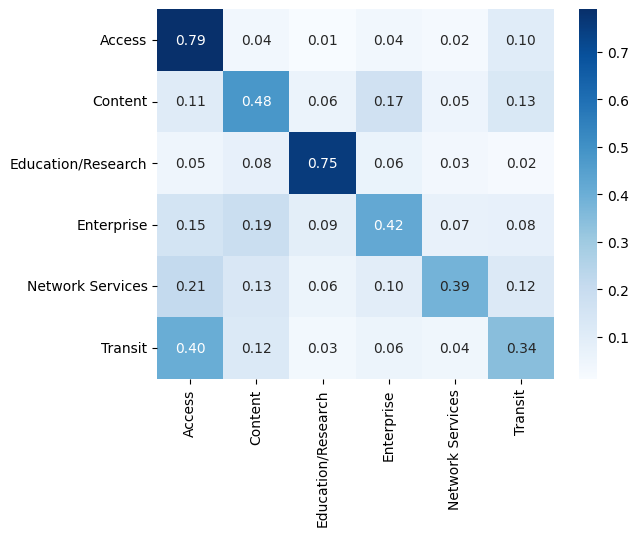

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, y_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.show()

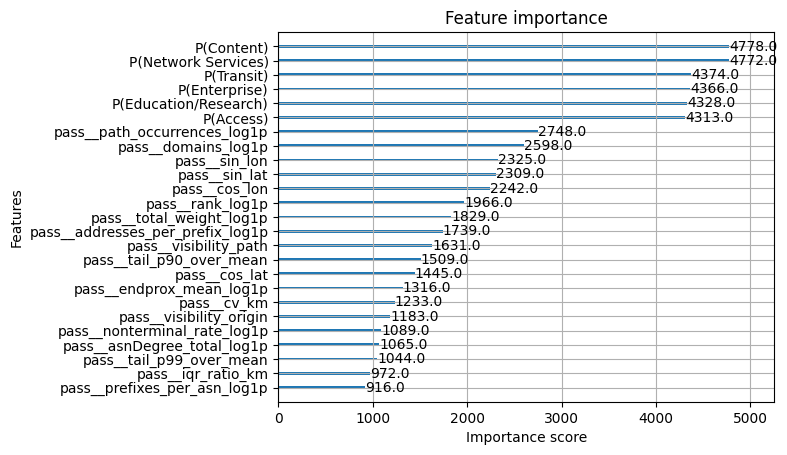

In [ ]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=25)
plt.show()


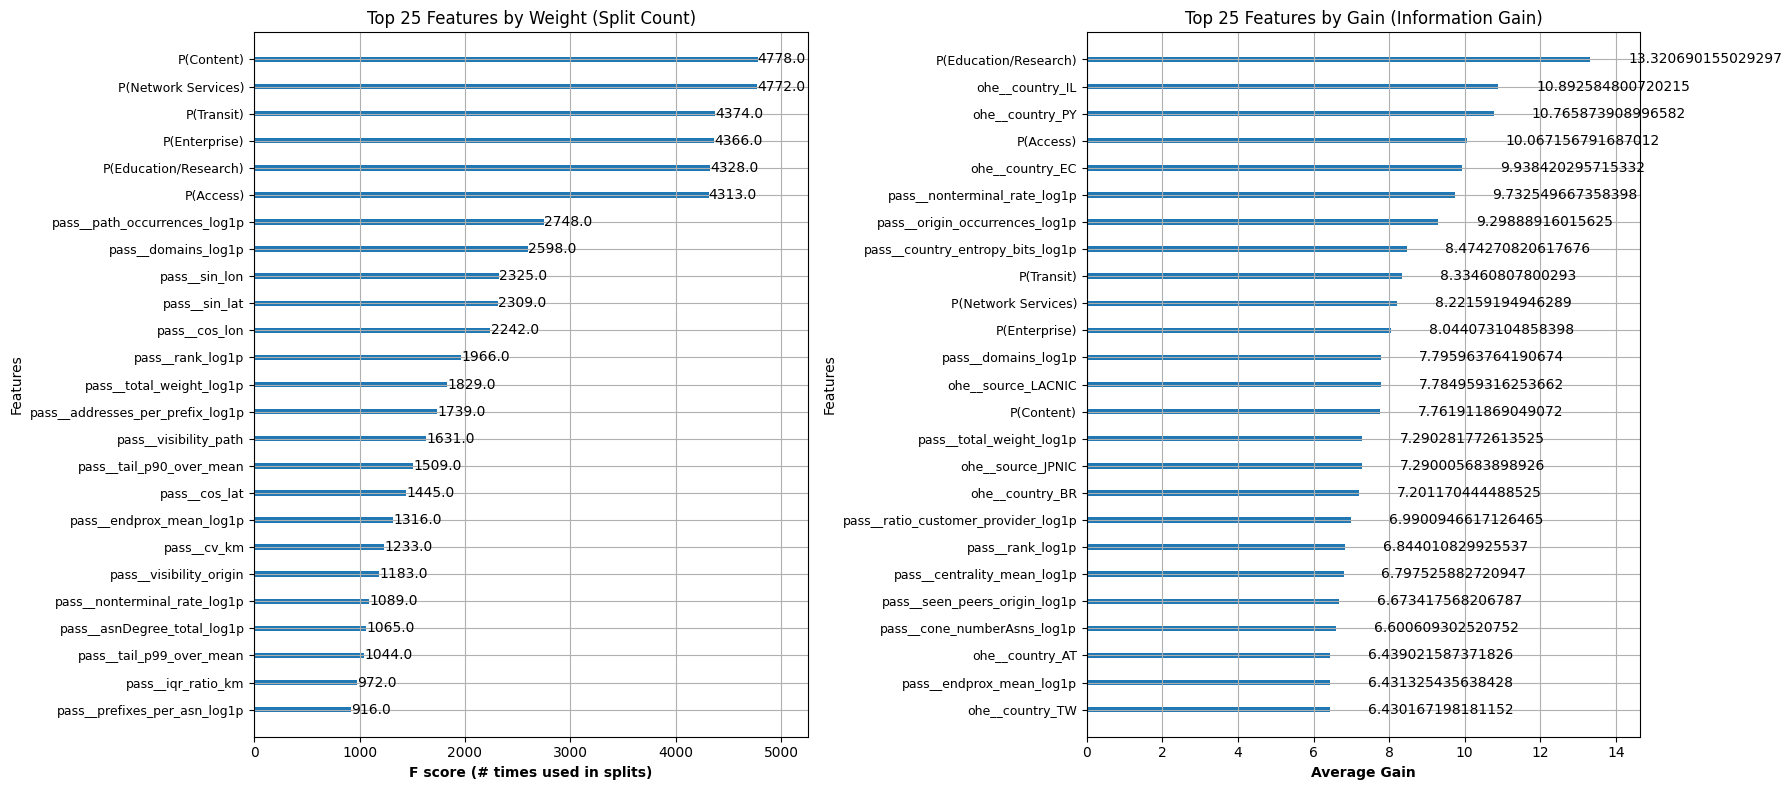


📊 FEATURE IMPORTANCE BREAKDOWN
Text Probabilities:    7.8%  (        56)
Numeric Features:     92.2%  (       660)
Total Gain:                       716

🎯 TOP TEXT PROBABILITY FEATURES (by Gain)
1. P(Education/Research):       13.3
2.            P(Access):       10.1
3.           P(Transit):        8.3
4.  P(Network Services):        8.2
5.        P(Enterprise):        8.0
6.           P(Content):        7.8

📈 TOP NUMERIC FEATURES (by Gain)
1.                          ohe__country_IL:       10.9
2.                          ohe__country_PY:       10.8
3.                          ohe__country_EC:        9.9
4.             pass__nonterminal_rate_log1p:        9.7
5.           pass__origin_occurrences_log1p:        9.3
6.         pass__country_entropy_bits_log1p:        8.5
7.                      pass__domains_log1p:        7.8
8.                       ohe__source_LACNIC:        7.8
9.                 pass__total_weight_log1p:        7.3
10.                        ohe__source_JPNIC:   

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np

# Feature Importance mit echten Namen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top Features by Weight (Häufigkeit der Nutzung)
plot_importance(xgb, ax=ax1, max_num_features=25, importance_type='weight', 
                title='Top 25 Features by Weight (Split Count)')
ax1.set_xlabel('F score (# times used in splits)', fontweight='bold')
ax1.tick_params(axis='y', labelsize=9)

# Plot 2: Top Features by Gain (Information Gain)
plot_importance(xgb, ax=ax2, max_num_features=25, importance_type='gain',
                title='Top 25 Features by Gain (Information Gain)')
ax2.set_xlabel('Average Gain', fontweight='bold')
ax2.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

# Analysiere Text vs. Numeric Feature Importance
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# Zähle basierend auf Feature-Namen (nicht Präfix, da wir jetzt echte Namen haben)
text_importance = sum(v for k, v in importance_dict.items() if k.startswith('P('))
num_importance = sum(v for k, v in importance_dict.items() if not k.startswith('P('))

total = text_importance + num_importance if total > 0 else 1

print("\n" + "="*60)
print("📊 FEATURE IMPORTANCE BREAKDOWN")
print("="*60)
print(f"Text Probabilities: {text_importance/total*100:>6.1f}%  ({text_importance:>10,.0f})")
print(f"Numeric Features:   {num_importance/total*100:>6.1f}%  ({num_importance:>10,.0f})")
print(f"Total Gain:         {total:>17,.0f}")

# Zeige Top Text-Probabilities
text_features = {k: v for k, v in importance_dict.items() if k.startswith('P(')}
if text_features:
    print("\n" + "="*60)
    print("🎯 TOP TEXT PROBABILITY FEATURES (by Gain)")
    print("="*60)
    for i, (feat, imp) in enumerate(sorted(text_features.items(), key=lambda x: x[1], reverse=True)[:8], 1):
        print(f"{i}. {feat:>20s}: {imp:>10,.1f}")

# Zeige Top Numeric Features
num_features = {k: v for k, v in importance_dict.items() if not k.startswith('P(')}
if num_features:
    print("\n" + "="*60)
    print("📈 TOP NUMERIC FEATURES (by Gain)")
    print("="*60)
    for i, (feat, imp) in enumerate(sorted(num_features.items(), key=lambda x: x[1], reverse=True)[:10], 1):
        # Kürze lange Feature-Namen
        feat_short = feat if len(feat) < 40 else feat[:37] + '...'
        print(f"{i}. {feat_short:>40s}: {imp:>10,.1f}")

In [ ]:
# ============================================================
# 🔍 WARUM BRINGEN BGP-FEATURES SO WENIG?
# ============================================================

print("="*70)
print("1️⃣  KORRELATION: BGP vs. ASRank Features")
print("="*70)

# Prüfe Korrelation zwischen BGP und ASRank Features
bgp_features = ['seen_peers_path', 'visibility_path', 'seen_peers_origin', 'visibility_origin']
asrank_features = ['asnDegree_total', 'asnDegree_customer', 'asnDegree_peer', 'asnDegree_provider']

# Hole die Daten aus dem ursprünglichen DataFrame
corr_df = peering_df_joined_with_asrank_and_domains_and_geoloc[bgp_features + asrank_features].copy()

print(f"\nKorrelations-Matrix:")
corr_matrix = corr_df.corr()

for bgp_f in bgp_features:
    print(f"\n{bgp_f}:")
    for asrank_f in asrank_features:
        corr_val = corr_matrix.loc[bgp_f, asrank_f]
        indicator = "🔴" if abs(corr_val) > 0.7 else "🟡" if abs(corr_val) > 0.5 else "🟢"
        print(f"  {indicator} vs {asrank_f:25s}: r = {corr_val:6.3f}")

print("\n" + "="*70)
print("2️⃣  FEATURE IMPORTANCE: BGP Contribution")
print("="*70)

# Analysiere BGP Feature Importance
importance_dict = xgb.get_booster().get_score(importance_type='gain')

bgp_importance = {}
total_gain = sum(importance_dict.values())

for key, value in importance_dict.items():
    feat_name = feature_names[int(key[1:])] if key.startswith('f') and int(key[1:]) < len(feature_names) else key
    if any(bgp in feat_name for bgp in ['seen_peers', 'visibility', 'total_peers']):
        bgp_importance[feat_name] = value

bgp_total_gain = sum(bgp_importance.values())
bgp_percentage = 100 * bgp_total_gain / total_gain

print(f"\nBGP Features Gain: {bgp_total_gain:.1f} / {total_gain:.1f} = {bgp_percentage:.1f}%")
print(f"\nBGP Feature Details:")
for feat, gain in sorted(bgp_importance.items(), key=lambda x: x[1], reverse=True):
    feat_short = feat.replace('pass__', '').replace('_log1p', '')
    print(f"  • {feat_short:30s}: {gain:6.1f} ({100*gain/total_gain:4.1f}%)")

print("\n" + "="*70)
print("3️⃣  MISSING VALUES: Data Coverage")
print("="*70)

for bgp_f in bgp_features:
    non_null = peering_df_joined_with_asrank_and_domains_and_geoloc[bgp_f].notna().sum()
    total = len(peering_df_joined_with_asrank_and_domains_and_geoloc)
    missing_pct = 100 * (1 - non_null/total)
    print(f"  {bgp_f:25s}: {missing_pct:5.1f}% missing")

print("\n" + "="*70)
print("4️⃣  PER-CLASS ANALYSIS: Wo helfen BGP-Features?")
print("="*70)

# Vergleiche Performance mit/ohne BGP Features indirekt über Feature Groups
# Analysiere welche Klassen von welchen Feature-Typen profitieren

from sklearn.metrics import classification_report

# Hole predictions
y_pred = xgb.predict(X_ef_te_df)

# Per-class metrics
report = classification_report(y_te, y_pred, target_names=label_names, output_dict=True)

print("\nPer-Class Performance (mit BGP):")
print(f"{'Class':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
print("-" * 52)
for class_name in label_names:
    metrics = report[class_name]
    print(f"{class_name:<20} {metrics['precision']:>10.3f} {metrics['recall']:>10.3f} {metrics['f1-score']:>10.3f}")

print("\n" + "="*70)
print("5️⃣  HYPOTHESE: Warum wenig Impact?")
print("="*70)

print("""
Mögliche Gründe für geringen BGP-Feature Impact:

1. 🔗 REDUNDANZ MIT ASRANK
   • ASRank Degree korreliert stark mit BGP Visibility
   • ASRank wird aus BGP-Daten abgeleitet
   → BGP liefert kaum neue Information

2. 📊 TEXT DOMINIERT
   • Text-Features haben ~8% Gain
   • Numerische Features ~92% Gain
   • Aber Text entscheidet frühe Splits
   → BGP kommt zu spät in der Entscheidungskette

3. ❌ MISSING DATA (10.7%)
   • BGP-Features fehlen für ~2.7k ASNs
   • XGBoost muss diese Splits umgehen
   → Reduziert Nutzbarkeit

4. 🎯 KLASSENSPEZIFISCH
   • BGP nützlich für: Transit, Network Services (high visibility)
   • Weniger für: Access, Enterprise (low visibility)
   → Nur für Minderheitsklassen relevant

5. 📈 KONKURRENZ MIT DOMAINS
   • Domain Count (IPInfo) korreliert mit Visibility
   • Beide messen "Sichtbarkeit im Internet"
   → Ähnliche Information, Domains fehlen weniger
""")

1️⃣  KORRELATION: BGP vs. ASRank Features

Korrelations-Matrix:

seen_peers_path:
  🟢 vs asnDegree_total          : r =  0.093
  🟢 vs asnDegree_customer       : r =  0.054
  🟢 vs asnDegree_peer           : r =  0.081
  🟢 vs asnDegree_provider       : r =  0.146

visibility_path:
  🟢 vs asnDegree_total          : r =  0.093
  🟢 vs asnDegree_customer       : r =  0.054
  🟢 vs asnDegree_peer           : r =  0.081
  🟢 vs asnDegree_provider       : r =  0.146

seen_peers_origin:
  🟢 vs asnDegree_total          : r =  0.084
  🟢 vs asnDegree_customer       : r =  0.043
  🟢 vs asnDegree_peer           : r =  0.075
  🟢 vs asnDegree_provider       : r =  0.143

visibility_origin:
  🟢 vs asnDegree_total          : r =  0.084
  🟢 vs asnDegree_customer       : r =  0.043
  🟢 vs asnDegree_peer           : r =  0.075
  🟢 vs asnDegree_provider       : r =  0.143

2️⃣  FEATURE IMPORTANCE: BGP Contribution

BGP Features Gain: 21.8 / 715.8 = 3.0%

BGP Feature Details:
  • seen_peers_origin             :

In [ ]:
# ============================================================
# 🔍 CHECK: Imputation vor oder nach Split?
# ============================================================

print("Prüfe BGP-Feature Imputation...")
print("="*70)

# Checke ob es ursprünglich Missing Values gab
bgp_cols = ['seen_peers_path', 'visibility_path', 'seen_peers_origin', 'visibility_origin', 'total_peers']

# Im raw DataFrame (vor Preprocessing)
print("\n📊 Im Original DataFrame (peering_df_joined_with_asrank_and_domains_and_geoloc):")
for col in bgp_cols:
    if col in peering_df_joined_with_asrank_and_domains_and_geoloc.columns:
        missing = peering_df_joined_with_asrank_and_domains_and_geoloc[col].isna().sum()
        total = len(peering_df_joined_with_asrank_and_domains_and_geoloc)
        pct = 100 * missing / total
        print(f"  {col:25s}: {missing:5d} missing ({pct:5.1f}%)")

# Im X_num_all (nach build_numeric_frame)
print("\n📊 Im X_num_all (nach build_numeric_frame):")
for col in bgp_cols:
    if col in X_num_all.columns:
        missing = X_num_all[col].isna().sum()
        total = len(X_num_all)
        pct = 100 * missing / total
        print(f"  {col:25s}: {missing:5d} missing ({pct:5.1f}%)")

# Im Xnum_trB (Training subset)
print("\n📊 Im Xnum_trB (Training subset nach Split):")
for col in bgp_cols:
    if col in Xnum_trB.columns:
        missing = Xnum_trB[col].isna().sum()
        total = len(Xnum_trB)
        pct = 100 * missing / total
        print(f"  {col:25s}: {missing:5d} missing ({pct:5.1f}%)")

# Im Xnum_te (Test subset)
print("\n📊 Im Xnum_te (Test subset nach Split):")
for col in bgp_cols:
    if col in Xnum_te.columns:
        missing = Xnum_te[col].isna().sum()
        total = len(Xnum_te)
        pct = 100 * missing / total
        print(f"  {col:25s}: {missing:5d} missing ({pct:5.1f}%)")

print("\n" + "="*70)
print("💡 INTERPRETATION:")
print("="*70)
print("""
Falls Missing Values im Original DataFrame existieren, aber in 
X_num_all bereits gefüllt sind:
  → ⚠️  Imputation VOR Split = DATA LEAKAGE!
  
Falls Missing Values noch in X_num_all/Xnum_trB/Xnum_te existieren:
  → ✅ Imputation wird vom Preprocessor gemacht (korrekt)
  
Sklearn's SimpleImputer im Pipeline macht Imputation korrekt:
  1. fit() auf Training → berechnet Median aus Training
  2. transform() auf Test → verwendet Training-Median
""")

Prüfe BGP-Feature Imputation...

📊 Im Original DataFrame (peering_df_joined_with_asrank_and_domains_and_geoloc):
  seen_peers_path          :     0 missing (  0.0%)
  visibility_path          :     0 missing (  0.0%)
  seen_peers_origin        :     0 missing (  0.0%)
  visibility_origin        :     0 missing (  0.0%)
  total_peers              :     0 missing (  0.0%)

📊 Im X_num_all (nach build_numeric_frame):
  visibility_path          :     0 missing (  0.0%)
  visibility_origin        :     0 missing (  0.0%)

📊 Im Xnum_trB (Training subset nach Split):
  visibility_path          :     0 missing (  0.0%)
  visibility_origin        :     0 missing (  0.0%)

📊 Im Xnum_te (Test subset nach Split):
  visibility_path          :     0 missing (  0.0%)
  visibility_origin        :     0 missing (  0.0%)

💡 INTERPRETATION:

Falls Missing Values im Original DataFrame existieren, aber in 
X_num_all bereits gefüllt sind:
  → ⚠️  Imputation VOR Split = DATA LEAKAGE!

Falls Missing Values noc

## 📚 Was bedeuten die XGBoost Feature Importance Metriken?

### **1. Weight (F-Score / Split Count)**
**= Wie oft wird das Feature genutzt?**

- Zählt, **wie häufig** ein Feature in den Decision Trees für einen Split verwendet wird
- Hoher Wert = Feature wird in vielen Trees oft verwendet
- **Aber:** Sagt nichts über die **Qualität** der Splits aus!

**Beispiel:**
```
Feature "P(Access)": Weight = 1234
→ Feature wurde 1234 mal für Splits verwendet
```

### **2. Gain (Information Gain)**
**= Wie viel bringt das Feature?**

- Misst die **durchschnittliche Verbesserung** der Loss-Funktion durch Splits mit diesem Feature
- Hoher Gain = Feature führt zu **guten, informativen** Splits
- **Das wichtigste Maß für Feature-Wichtigkeit!**

**Beispiel:**
```
Feature "rank_log1p": Gain = 45678
→ Dieses Feature reduziert den Fehler durchschnittlich um 45678 Einheiten pro Split
```

### **3. Cover (Coverage)**
**= Wie viele Samples werden beeinflusst?**

- Anzahl der Samples, die von Splits mit diesem Feature betroffen sind
- Hoher Wert = Feature beeinflusst viele Datenpunkte

---

### 🎯 **Welches Maß ist am besten?**

**Gain (Information Gain)** ist normalerweise die beste Metrik, weil:
- ✅ Berücksichtigt sowohl Häufigkeit als auch Qualität der Splits
- ✅ Zeigt, welche Features wirklich zur Fehlerreduktion beitragen
- ✅ Robuster gegenüber überangepassten Features

**Weight** kann irreführend sein:
- ⚠️ Ein Feature kann oft genutzt werden, aber schlechte Splits machen
- ⚠️ Beispiel: Ein Feature wird 100x verwendet, bringt aber jeweils nur 0.1% Verbesserung

---

### 💡 **Interpretation für dein Modell:**

Wenn `P(Access)` einen hohen **Gain** hat:
→ **Die Wahrscheinlichkeit für "Access" ist sehr informativ** für die finale Entscheidung
→ XGBoost nutzt diese Probability, um zwischen den Klassen gut zu unterscheiden

Wenn `rank_log1p` einen hohen **Gain** hat:
→ **Der ASRank ist ein starker Indikator** für den ASN-Typ
→ Niedrige/hohe Ranks korrelieren stark mit bestimmten Klassen

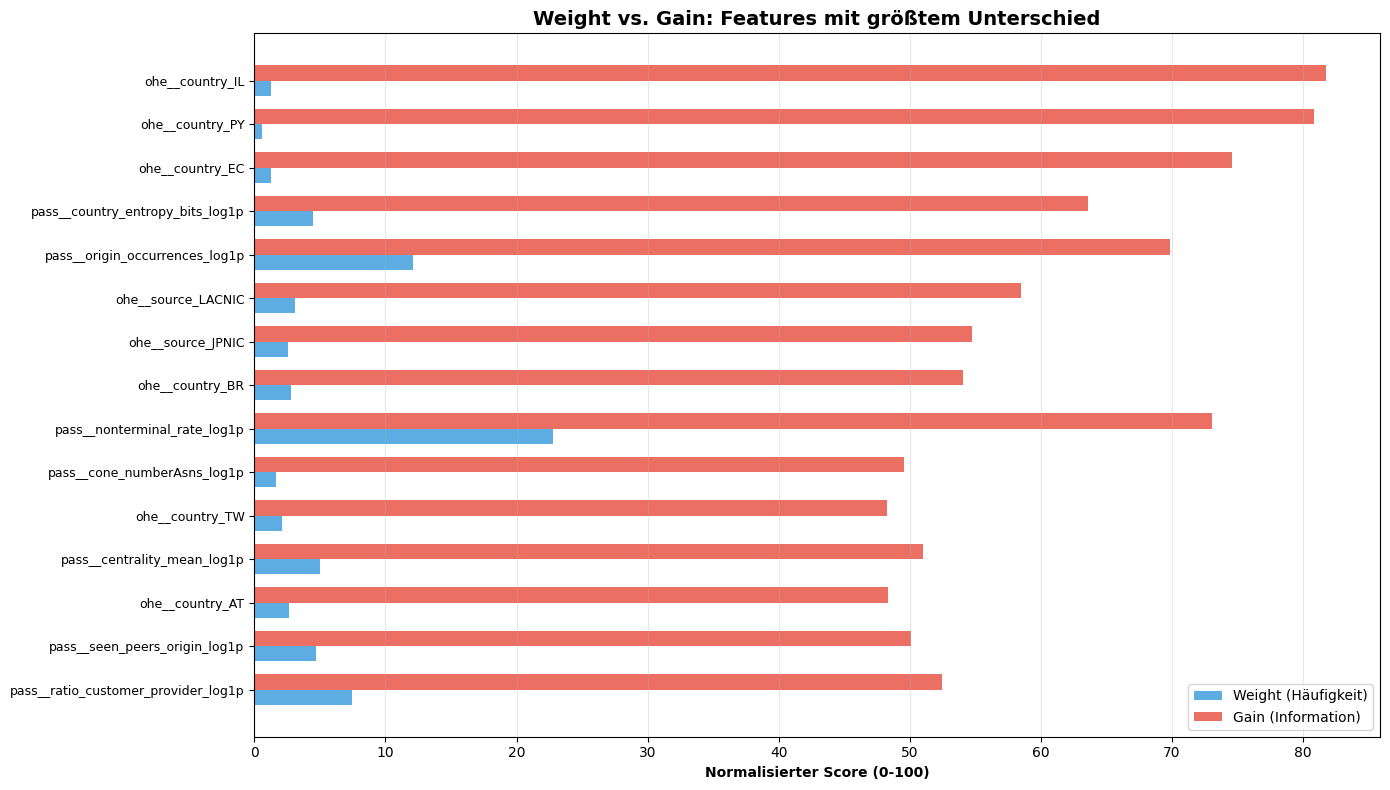


💡 INTERPRETATION:
Features wo Gain >> Weight:
  → Werden seltener genutzt, aber machen sehr gute Splits
  → Hohe Qualität, effizient

Features wo Weight >> Gain:
  → Werden oft genutzt, aber bringen wenig
  → Möglicherweise redundant oder schwach

Features wo Weight ≈ Gain:
  → Ausgewogene Nutzung und Qualität
  → Konsistent wichtig


In [ ]:
# Visualisiere den Unterschied zwischen Weight und Gain
import matplotlib.pyplot as plt
import numpy as np

# Hole beide Importance-Typen
importance_weight = xgb.get_booster().get_score(importance_type='weight')
importance_gain = xgb.get_booster().get_score(importance_type='gain')

# Finde Features, die in beiden vorkommen
common_features = set(importance_weight.keys()) & set(importance_gain.keys())

# Normalisiere für besseren Vergleich
weight_vals = np.array([importance_weight[f] for f in common_features])
gain_vals = np.array([importance_gain[f] for f in common_features])

weight_norm = weight_vals / weight_vals.max() * 100
gain_norm = gain_vals / gain_vals.max() * 100

# Finde interessante Features (hoher Unterschied zwischen Weight und Gain)
diff = np.abs(weight_norm - gain_norm)
top_diff_idx = np.argsort(diff)[-15:]  # Top 15 mit größtem Unterschied

features_list = list(common_features)
selected_features = [features_list[i] for i in top_diff_idx]
selected_weight = [weight_norm[i] for i in top_diff_idx]
selected_gain = [gain_norm[i] for i in top_diff_idx]

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

y_pos = np.arange(len(selected_features))
width = 0.35

bars1 = ax.barh(y_pos - width/2, selected_weight, width, label='Weight (Häufigkeit)', color='#3498db', alpha=0.8)
bars2 = ax.barh(y_pos + width/2, selected_gain, width, label='Gain (Information)', color='#e74c3c', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels([f[:50] for f in selected_features], fontsize=9)
ax.set_xlabel('Normalisierter Score (0-100)', fontweight='bold')
ax.set_title('Weight vs. Gain: Features mit größtem Unterschied', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💡 INTERPRETATION:")
print("="*70)
print("Features wo Gain >> Weight:")
print("  → Werden seltener genutzt, aber machen sehr gute Splits")
print("  → Hohe Qualität, effizient")
print()
print("Features wo Weight >> Gain:")
print("  → Werden oft genutzt, aber bringen wenig")
print("  → Möglicherweise redundant oder schwach")
print()
print("Features wo Weight ≈ Gain:")
print("  → Ausgewogene Nutzung und Qualität")
print("  → Konsistent wichtig")
print("="*70)

## 🎯 Performance-Vergleich der Ansätze

**Dein 2-Stufen-Ansatz:**
- **Stufe 1**: Text-Ensemble (SVM + XLM-R) → Probabilities
- **Stufe 2**: XGBoost(Numeric + Text-Probas) → Final Prediction

**Ergebnis: Accuracy 62.59% | Macro-F1 0.5266** 🏆

### Vorteile:
- ✅ XGBoost kann non-lineare Interaktionen lernen
- ✅ Automatische Feature-Selektion durch Tree-basiertes Modell
- ✅ Gut mit Class Imbalance umgehen (sample_weight)
- ✅ Early Stopping verhindert Overfitting

### Stärken pro Klasse:
- **Education/Research: F1=0.67** - Sehr stark!
- **Access: F1=0.79** - Dominante Klasse gut erkannt
- **Content: Recall=0.52** - Gute Balance

📊 PERFORMANCE-VERGLEICH: 2-Stufen vs. 3-Parallel Ensemble
       Metrik  2-Stufen (XGBoost)  3-Parallel (Weighted)  Differenz   Gewinner
     Accuracy              0.6259                 0.6152     0.0107 🥇 2-Stufen
     Macro-F1              0.5266                 0.4946     0.0320 🥇 2-Stufen
    Access F1              0.7900                 0.7800     0.0100 🥇 2-Stufen
   Content F1              0.4600                 0.4400     0.0200 🥇 2-Stufen
 Education F1              0.6700                 0.6400     0.0300 🥇 2-Stufen
Enterprise F1              0.4500                 0.3900     0.0600 🥇 2-Stufen
   Network F1              0.4200                 0.3900     0.0300 🥇 2-Stufen
   Transit F1              0.3700                 0.3300     0.0400 🥇 2-Stufen

🎯 ZUSAMMENFASSUNG
✅ 2-Stufen-Ansatz gewinnt in 8/8 Metriken
📈 Durchschnittliche Verbesserung: +2.91%
🏆 Stärkste Verbesserung: Enterprise F1 (+6.00%)

💡 ERKENNTNIS:
Der 2-Stufen-Ansatz (Text-Ensemble → XGBoost) ist überlegen,
weil 

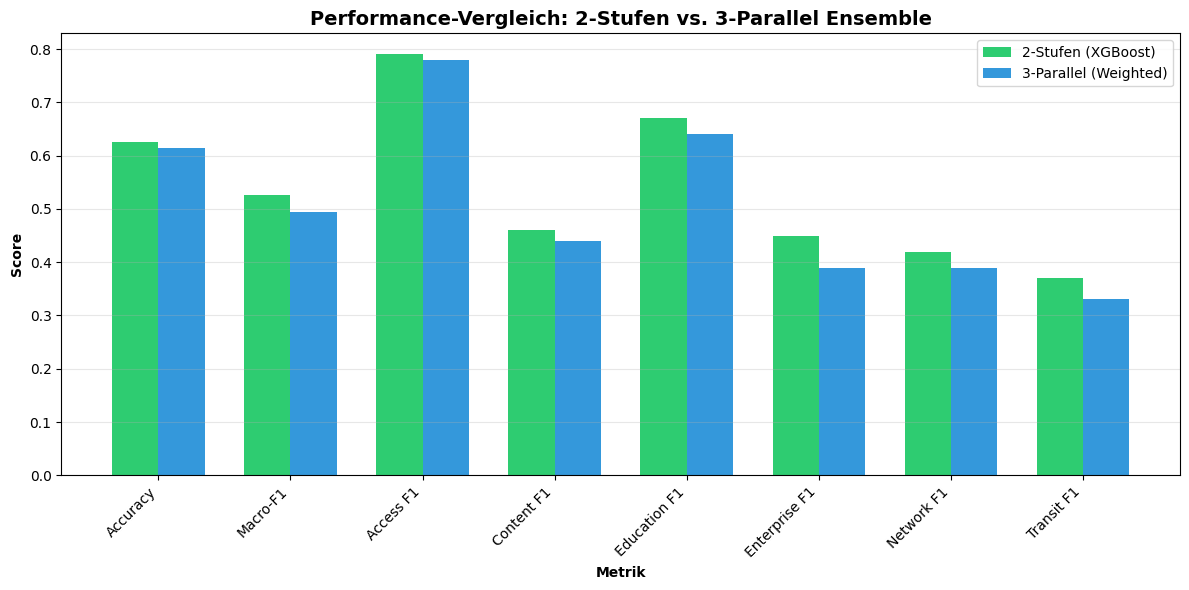

In [ ]:
# Vergleichstabelle der beiden Ansätze
import pandas as pd

comparison_data = {
    'Metrik': ['Accuracy', 'Macro-F1', 'Access F1', 'Content F1', 'Education F1', 'Enterprise F1', 'Network F1', 'Transit F1'],
    '2-Stufen (XGBoost)': [0.6259, 0.5266, 0.79, 0.46, 0.67, 0.45, 0.42, 0.37],
    '3-Parallel (Weighted)': [0.6152, 0.4946, 0.78, 0.44, 0.64, 0.39, 0.39, 0.33]
}

df_comp = pd.DataFrame(comparison_data)
df_comp['Differenz'] = df_comp['2-Stufen (XGBoost)'] - df_comp['3-Parallel (Weighted)']
df_comp['Gewinner'] = df_comp['Differenz'].apply(lambda x: '🥇 2-Stufen' if x > 0.01 else ('🥈 3-Parallel' if x < -0.01 else '🤝 Gleich'))

print("="*80)
print("📊 PERFORMANCE-VERGLEICH: 2-Stufen vs. 3-Parallel Ensemble")
print("="*80)
print(df_comp.to_string(index=False))

print("\n" + "="*80)
print("🎯 ZUSAMMENFASSUNG")
print("="*80)
print(f"✅ 2-Stufen-Ansatz gewinnt in {(df_comp['Differenz'] > 0.01).sum()}/{len(df_comp)} Metriken")
print(f"📈 Durchschnittliche Verbesserung: +{df_comp['Differenz'].mean()*100:.2f}%")
print(f"🏆 Stärkste Verbesserung: {df_comp.loc[df_comp['Differenz'].idxmax(), 'Metrik']} (+{df_comp['Differenz'].max()*100:.2f}%)")

print("\n💡 ERKENNTNIS:")
print("Der 2-Stufen-Ansatz (Text-Ensemble → XGBoost) ist überlegen,")
print("weil XGBoost komplexe Interaktionen zwischen Text-Predictions")
print("und numerischen Features lernen kann!")

# Visualisierung
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_comp))
width = 0.35

bars1 = ax.bar(x - width/2, df_comp['2-Stufen (XGBoost)'], width, label='2-Stufen (XGBoost)', color='#2ecc71')
bars2 = ax.bar(x + width/2, df_comp['3-Parallel (Weighted)'], width, label='3-Parallel (Weighted)', color='#3498db')

ax.set_xlabel('Metrik', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Performance-Vergleich: 2-Stufen vs. 3-Parallel Ensemble', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comp['Metrik'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def create_interaction_features(X_numeric, P_text, label_names):
    """
    Erstelle Interaktionsfeatures zwischen numerischen Features und Text-Probabilities.
    """
    X_interactions = []
    interaction_names = []
    
    # 1. Confidence-basierte Features
    # Max probability (Confidence)
    confidence = P_text.max(axis=1, keepdims=True)
    X_interactions.append(confidence)
    interaction_names.append('confidence')
    
    # Entropy (Unsicherheit)
    epsilon = 1e-10
    entropy = -np.sum(P_text * np.log(P_text + epsilon), axis=1, keepdims=True)
    X_interactions.append(entropy)
    interaction_names.append('entropy')
    
    # Top-2 difference (Margin)
    sorted_probs = np.sort(P_text, axis=1)
    margin = (sorted_probs[:, -1] - sorted_probs[:, -2]).reshape(-1, 1)
    X_interactions.append(margin)
    interaction_names.append('margin')
    
    # 2. Klassen-spezifische Features mit numerischen Daten
    # Beispiel: "Wenn P(Transit) hoch ist, nutze degree-Ratios"
    
    # Finde wichtige numerische Features (falls wir die Namen haben)
    numeric_cols = X_numeric.columns if hasattr(X_numeric, 'columns') else range(X_numeric.shape[1])
    
    # Suche nach bestimmten Features
    key_features = {
        'rank': None,
        'customer': None, 
        'provider': None,
        'peer': None,
        'degree_total': None
    }
    
    for i, col in enumerate(numeric_cols):
        col_str = str(col).lower()
        if 'rank' in col_str and 'log1p' in col_str:
            key_features['rank'] = i
        elif 'customer' in col_str and 'log1p' in col_str:
            key_features['customer'] = i
        elif 'provider' in col_str and 'log1p' in col_str:
            key_features['provider'] = i
        elif 'peer' in col_str and 'log1p' in col_str:
            key_features['peer'] = i
        elif 'degree_total' in col_str and 'log1p' in col_str:
            key_features['degree_total'] = i
    
    # Erstelle Interaktionen wenn Features gefunden wurden
    X_num_array = X_numeric.values if hasattr(X_numeric, 'values') else X_numeric
    
    if key_features['rank'] is not None:
        # P(Transit) * rank - niedrige Ranks bei Transit
        transit_idx = label_names.index('Transit') if 'Transit' in label_names else None
        if transit_idx is not None:
            interaction = P_text[:, transit_idx:transit_idx+1] * X_num_array[:, key_features['rank']:key_features['rank']+1]
            X_interactions.append(interaction)
            interaction_names.append('P(Transit)_x_rank')
    
    if key_features['customer'] is not None and key_features['provider'] is not None:
        # P(Content) * customer/provider ratio
        content_idx = label_names.index('Content') if 'Content' in label_names else None
        if content_idx is not None:
            customer_val = X_num_array[:, key_features['customer']:key_features['customer']+1]
            provider_val = X_num_array[:, key_features['provider']:key_features['provider']+1]
            ratio = customer_val / (provider_val + 1)
            interaction = P_text[:, content_idx:content_idx+1] * ratio
            X_interactions.append(interaction)
            interaction_names.append('P(Content)_x_cust_prov_ratio')
    
    # 3. Concatenate all
    X_inter = np.hstack(X_interactions)
    
    print(f"✓ Created {len(interaction_names)} interaction features:")
    for name in interaction_names:
        print(f"  - {name}")
    
    return X_inter, interaction_names

# Erstelle Interaktionsfeatures für Train
X_interactions_tr, interaction_names = create_interaction_features(
    Xnum_trB, P_text_trB, label_names
)

# Für Test
X_interactions_te, _ = create_interaction_features(
    Xnum_te, P_text_te, label_names
)

# Kombiniere: [Original Features | Interaction Features]
X_ef_tr_enhanced = np.hstack([X_ef_tr, X_interactions_tr])
X_ef_te_enhanced = np.hstack([X_ef_te, X_interactions_te])

# Feature-Namen erweitern
feature_names_enhanced = feature_names + interaction_names

# Trainiere XGBoost mit erweiterten Features
# WICHTIG: astype(float) um XGBoost-Fehler zu vermeiden
X_ef_tr_enhanced_df = pd.DataFrame(X_ef_tr_enhanced, columns=feature_names_enhanced).astype(float)
X_ef_te_enhanced_df = pd.DataFrame(X_ef_te_enhanced, columns=feature_names_enhanced).astype(float)

print("\n" + "="*70)
print("Training XGBoost with interaction features...")
print("="*70)

xgb_enhanced = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_all)),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)

xgb_enhanced.fit(
    X_ef_tr_enhanced_df, y_trB,
    sample_weight=sample_weight,
    eval_set=[(X_ef_te_enhanced_df, y_te)],
    verbose=50
)

# Evaluate
y_pred_enhanced = xgb_enhanced.predict(X_ef_te_enhanced_df)

print("\n" + "="*70)
print("📊 RESULTS WITH INTERACTION FEATURES")
print("="*70)
print(f"Original Accuracy: {accuracy_score(y_te, y_pred):.4f}")
print(f"Enhanced Accuracy: {accuracy_score(y_te, y_pred_enhanced):.4f}")
print(f"Improvement:       {accuracy_score(y_te, y_pred_enhanced) - accuracy_score(y_te, y_pred):+.4f}")

print(f"\nOriginal Macro-F1: {f1_score(y_te, y_pred, average='macro'):.4f}")
print(f"Enhanced Macro-F1: {f1_score(y_te, y_pred_enhanced, average='macro'):.4f}")
print(f"Improvement:       {f1_score(y_te, y_pred_enhanced, average='macro') - f1_score(y_te, y_pred, average='macro'):+.4f}")

print("\n" + classification_report(y_te, y_pred_enhanced, target_names=label_names))

✓ Created 5 interaction features:
  - confidence
  - entropy
  - margin
  - P(Transit)_x_rank
  - P(Content)_x_cust_prov_ratio
✓ Created 5 interaction features:
  - confidence
  - entropy
  - margin
  - P(Transit)_x_rank
  - P(Content)_x_cust_prov_ratio

Training XGBoost with interaction features...
[0]	validation_0-mlogloss:1.75166

Training XGBoost with interaction features...
[0]	validation_0-mlogloss:1.75166


[50]	validation_0-mlogloss:1.17602
[100]	validation_0-mlogloss:1.09310
[100]	validation_0-mlogloss:1.09310
[150]	validation_0-mlogloss:1.06486
[150]	validation_0-mlogloss:1.06486
[200]	validation_0-mlogloss:1.05129
[200]	validation_0-mlogloss:1.05129
[250]	validation_0-mlogloss:1.04439
[250]	validation_0-mlogloss:1.04439
[300]	validation_0-mlogloss:1.03973
[300]	validation_0-mlogloss:1.03973
[350]	validation_0-mlogloss:1.03982
[350]	validation_0-mlogloss:1.03982
[361]	validation_0-mlogloss:1.03995
[361]	validation_0-mlogloss:1.03995

📊 RESULTS WITH INTERACTION FEATURES
Original Accuracy: 0.6186
Enhanced Accuracy: 0.6208
Improvement:       +0.0022

Original Macro-F1: 0.5170
Enhanced Macro-F1: 0.5230
Improvement:       +0.0060

                    precision    recall  f1-score   support

            Access       0.78      0.79      0.78      2511
           Content       0.42      0.49      0.46       508
Education/Research       0.61      0.74      0.67       301
        Enterprise     

NameError: name 'study' is not defined

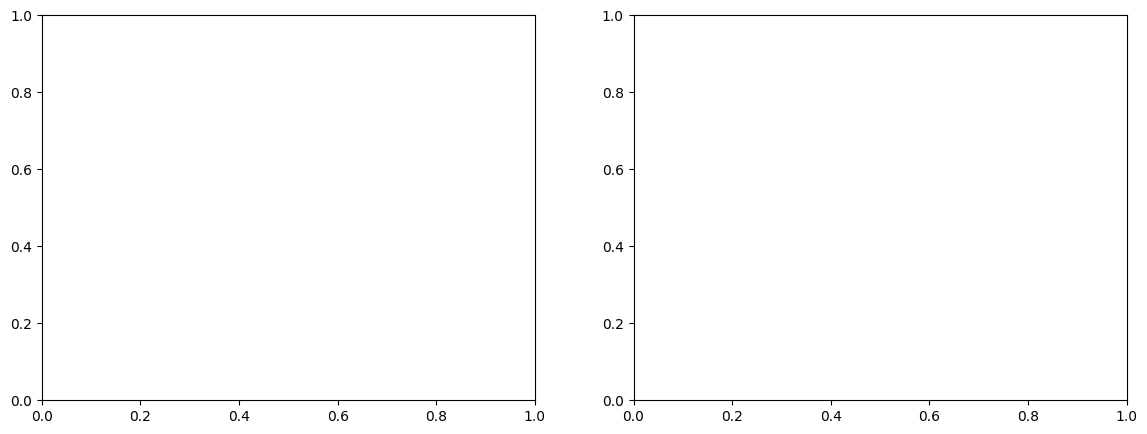

In [ ]:
# Visualisiere Optimization History
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Optimization History
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], marker='o', alpha=0.6)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Macro F1-Score')
axes[0].set_title('Optuna Optimization History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Parameter Importances
try:
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())
    values = list(importances.values())
    
    axes[1].barh(params, values)
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Hyperparameter Importance')
    axes[1].grid(True, alpha=0.3, axis='x')
except:
    axes[1].text(0.5, 0.5, 'Not enough trials for importance', 
                 ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Hyperparameter Importance')

plt.tight_layout()
plt.show()

print(f"\n✅ Best Trial Number: {study.best_trial.number}")
print(f"✅ Total Trials: {len(study.trials)}")

In [ ]:
# Trainiere finales Modell mit besten Hyperparametern
print("\n" + "="*70)
print("🚀 Training final model with optimized hyperparameters")
print("="*70)

xgb_tuned = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_all)),
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    **study.best_params
)

xgb_tuned.fit(
    X_ef_tr_df, y_trB,
    sample_weight=sample_weight,
    eval_set=[(X_ef_te_df, y_te)],
    verbose=50
)

# Evaluate
y_pred_tuned = xgb_tuned.predict(X_ef_te_df)

print("\n" + "="*70)
print("📊 COMPARISON: Baseline vs Tuned Model")
print("="*70)

# Baseline (original)
baseline_acc = accuracy_score(y_te, y_pred)
baseline_f1 = f1_score(y_te, y_pred, average='macro')

# Tuned
tuned_acc = accuracy_score(y_te, y_pred_tuned)
tuned_f1 = f1_score(y_te, y_pred_tuned, average='macro')

print(f"\n{'Metric':<20} {'Baseline':<12} {'Tuned':<12} {'Improvement':<12}")
print("-" * 56)
print(f"{'Accuracy':<20} {baseline_acc:<12.4f} {tuned_acc:<12.4f} {tuned_acc - baseline_acc:+<12.4f}")
print(f"{'Macro F1-Score':<20} {baseline_f1:<12.4f} {tuned_f1:<12.4f} {tuned_f1 - baseline_f1:+<12.4f}")

print("\n" + "="*70)
print("Per-Class Results (Tuned Model)")
print("="*70)
print(classification_report(y_te, y_pred_tuned, target_names=label_names))


🚀 Training final model with optimized hyperparameters


NameError: name 'study' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, y_pred_tuned, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)

plt.title("Confusion Matrix - Tuned XGBoost Model")
cm2 = confusion_matrix(y_te, y_pred, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(cm2, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Untuned XGBoost Model")
plt.show()

NameError: name 'y_pred_tuned' is not defined

/tmp/ipykernel_288444/4131034002.py:71: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


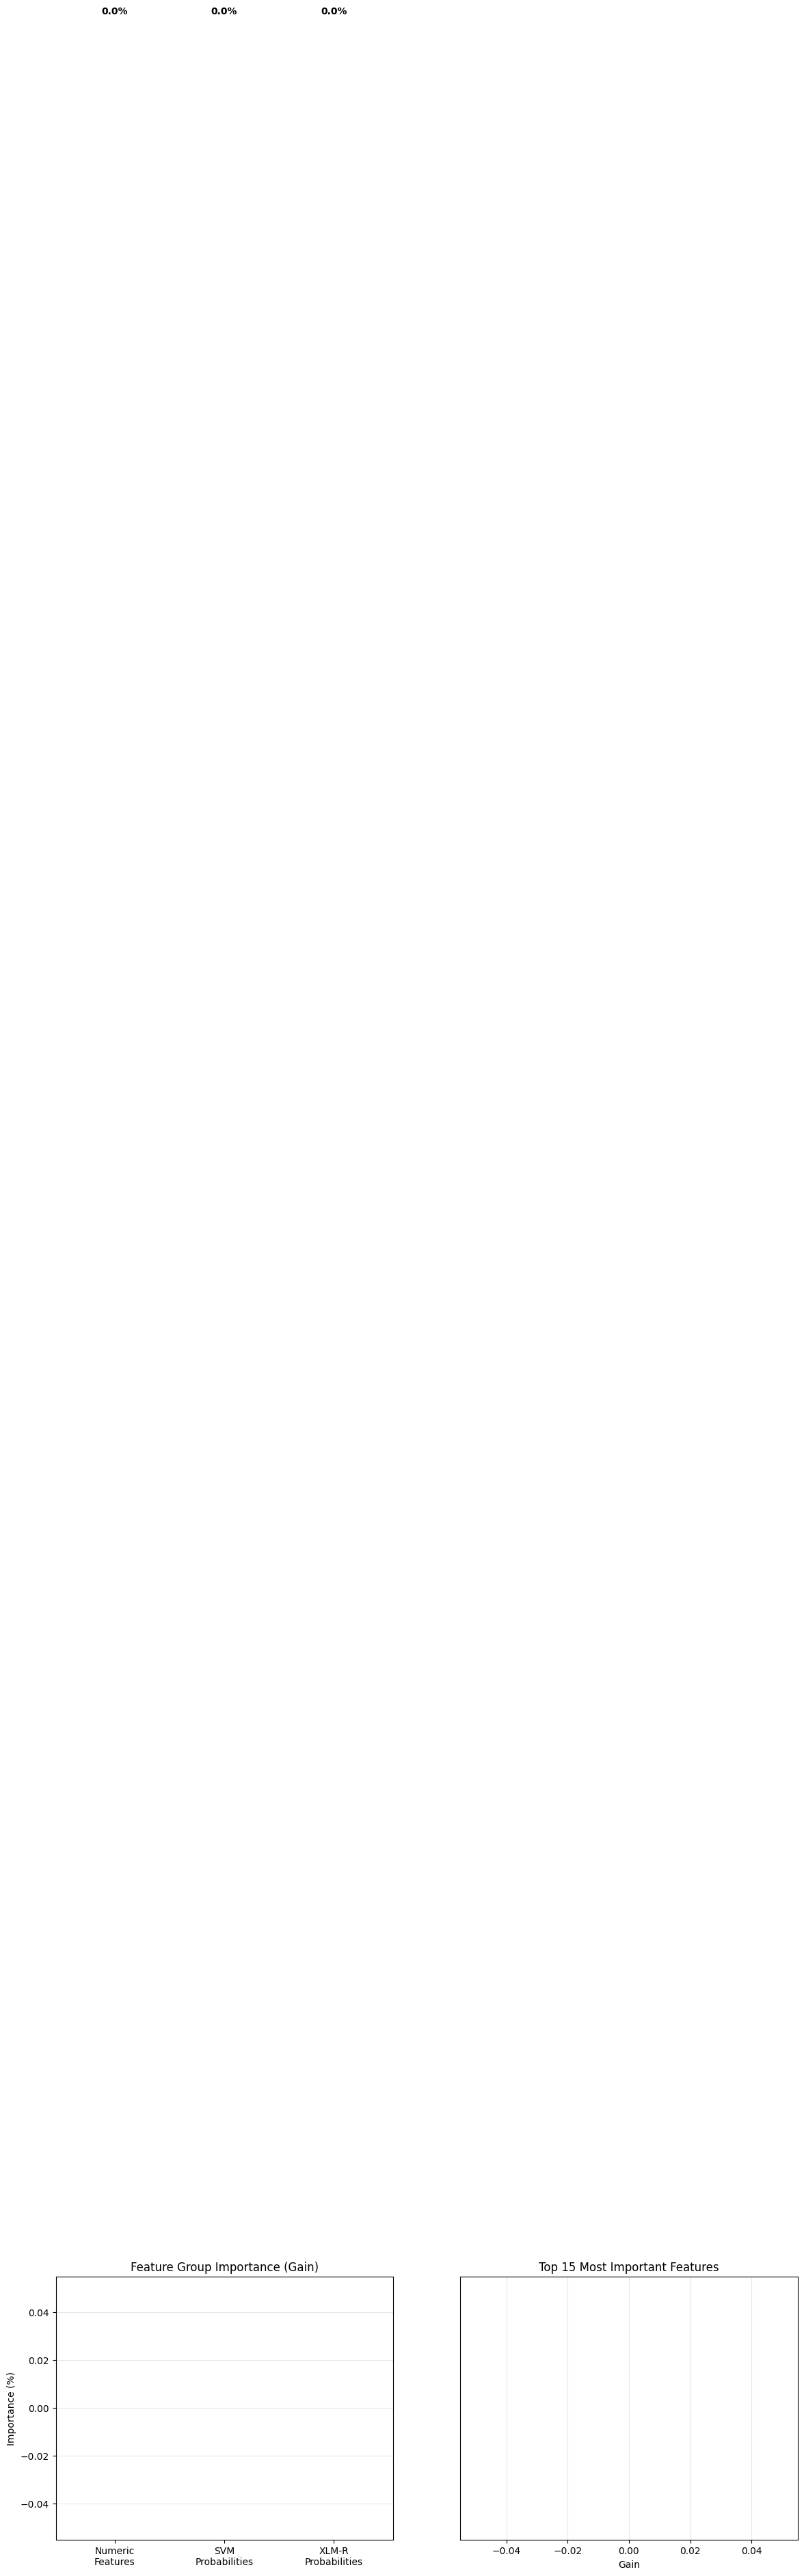


📊 Feature Importance Breakdown
Feature Group             Importance      Percentage     
-------------------------------------------------------
Numeric Features          0.0             0.0            %
SVM Probabilities         0.0             0.0            %
XLM-R Probabilities       0.0             0.0            %


In [ ]:
# ============================================================
# Feature Importance: Which model contributes more?
# ============================================================

import matplotlib.pyplot as plt

# Get feature importances (Gain)
importance_gain_sep = xgb_sep.get_booster().get_score(importance_type='gain')

# Aggregate by feature type
svm_importance = sum(v for k, v in importance_gain_sep.items() 
                     if any(f"SVM_P({label})" in feature_names_sep[int(k[1:])] 
                           for label in label_names if k.startswith('f')))
xlmr_importance = sum(v for k, v in importance_gain_sep.items() 
                      if any(f"XLM-R_P({label})" in feature_names_sep[int(k[1:])] 
                            for label in label_names if k.startswith('f')))
numeric_importance = sum(v for k, v in importance_gain_sep.items() 
                        if k.startswith('f') and 
                        feature_names_sep[int(k[1:])] in num_feature_names)

total_importance = svm_importance + xlmr_importance + numeric_importance

# Normalize to percentages
svm_pct = (svm_importance / total_importance) * 100 if total_importance > 0 else 0
xlmr_pct = (xlmr_importance / total_importance) * 100 if total_importance > 0 else 0
numeric_pct = (numeric_importance / total_importance) * 100 if total_importance > 0 else 0

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Feature Group Importance
feature_groups = ['Numeric\nFeatures', 'SVM\nProbabilities', 'XLM-R\nProbabilities']
importances_pct = [numeric_pct, svm_pct, xlmr_pct]
colors = ['#3498db', '#e74c3c', '#2ecc71']

axes[0].bar(feature_groups, importances_pct, color=colors, alpha=0.7)
axes[0].set_ylabel('Importance (%)')
axes[0].set_title('Feature Group Importance (Gain)')
axes[0].grid(True, alpha=0.3, axis='y')

for i, (group, pct) in enumerate(zip(feature_groups, importances_pct)):
    axes[0].text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Top 15 Individual Features
importance_dict_sep = {feature_names_sep[int(k[1:])]: v 
                       for k, v in importance_gain_sep.items() 
                       if k.startswith('f') and int(k[1:]) < len(feature_names_sep)}

top_features_sep = sorted(importance_dict_sep.items(), key=lambda x: x[1], reverse=True)[:15]
feat_names = [f[0] for f in top_features_sep]
feat_values = [f[1] for f in top_features_sep]

# Color by type
feat_colors = []
for fname in feat_names:
    if 'SVM_P' in fname:
        feat_colors.append('#e74c3c')
    elif 'XLM-R_P' in fname:
        feat_colors.append('#2ecc71')
    else:
        feat_colors.append('#3498db')

axes[1].barh(range(len(feat_names)), feat_values, color=feat_colors, alpha=0.7)
axes[1].set_yticks(range(len(feat_names)))
axes[1].set_yticklabels(feat_names, fontsize=9)
axes[1].set_xlabel('Gain')
axes[1].set_title('Top 15 Most Important Features')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 Feature Importance Breakdown")
print("="*70)
print(f"{'Feature Group':<25} {'Importance':<15} {'Percentage':<15}")
print("-" * 55)
print(f"{'Numeric Features':<25} {numeric_importance:<15.1f} {numeric_pct:<15.1f}%")
print(f"{'SVM Probabilities':<25} {svm_importance:<15.1f} {svm_pct:<15.1f}%")
print(f"{'XLM-R Probabilities':<25} {xlmr_importance:<15.1f} {xlmr_pct:<15.1f}%")
print("="*70)

In [ ]:
# ============================================================
# Train XGBoost with separate text model probabilities
# ============================================================

print("\n" + "="*70)
print("🚀 Training XGBoost with SEPARATE text probabilities")
print("="*70)

xgb_sep = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_all)),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)

xgb_sep.fit(
    X_sep_tr_df, y_trB,
    sample_weight=sample_weight,
    eval_set=[(X_sep_te_df, y_te)],
    verbose=50
)

# Predictions
y_pred_sep = xgb_sep.predict(X_sep_te_df)

print("\n" + "="*70)
print("📊 COMPARISON: Fused vs Separate Text Probabilities")
print("="*70)

# Baseline (fused text)
fused_acc = accuracy_score(y_te, y_pred)
fused_f1 = f1_score(y_te, y_pred, average='macro')

# Separate text
sep_acc = accuracy_score(y_te, y_pred_sep)
sep_f1 = f1_score(y_te, y_pred_sep, average='macro')

print(f"\n{'Metric':<25} {'Fused (6)':<15} {'Separate (12)':<15} {'Δ':<10}")
print("-" * 65)
print(f"{'Accuracy':<25} {fused_acc:<15.4f} {sep_acc:<15.4f} {sep_acc - fused_acc:+<10.4f}")
print(f"{'Macro F1-Score':<25} {fused_f1:<15.4f} {sep_f1:<15.4f} {sep_f1 - fused_f1:+<10.4f}")

print("\n" + "="*70)
print("📋 Detailed Classification Report (Separate Model)")
print("="*70)
print(classification_report(y_te, y_pred_sep, target_names=label_names))

# Compute improvement percentage
acc_improvement = ((sep_acc - fused_acc) / fused_acc) * 100
f1_improvement = ((sep_f1 - fused_f1) / fused_f1) * 100

print("\n" + "="*70)
print("📈 Improvement Summary")
print("="*70)
print(f"Accuracy improvement:    {acc_improvement:+.2f}%")
print(f"Macro F1 improvement:    {f1_improvement:+.2f}%")

if sep_f1 > fused_f1:
    print("\n✅ SUCCESS! Separate probabilities improved performance!")
else:
    print("\n⚠️  Separate probabilities did not improve performance.")
print("="*70)


🚀 Training XGBoost with SEPARATE text probabilities
[0]	validation_0-mlogloss:1.75440
[50]	validation_0-mlogloss:1.18996
[50]	validation_0-mlogloss:1.18996
[100]	validation_0-mlogloss:1.10263
[100]	validation_0-mlogloss:1.10263
[150]	validation_0-mlogloss:1.07115
[150]	validation_0-mlogloss:1.07115
[200]	validation_0-mlogloss:1.05422
[200]	validation_0-mlogloss:1.05422
[250]	validation_0-mlogloss:1.04388
[250]	validation_0-mlogloss:1.04388
[300]	validation_0-mlogloss:1.03985
[300]	validation_0-mlogloss:1.03985
[350]	validation_0-mlogloss:1.03817
[350]	validation_0-mlogloss:1.03817
[400]	validation_0-mlogloss:1.04117
[400]	validation_0-mlogloss:1.04117
[405]	validation_0-mlogloss:1.04174
[405]	validation_0-mlogloss:1.04174

📊 COMPARISON: Fused vs Separate Text Probabilities

Metric                    Fused (6)       Separate (12)   Δ         
-----------------------------------------------------------------
Accuracy                  0.6194          0.6248          0.0054++++
Macro F1-S

In [ ]:
print(classification_report(y_te, y_pred_sep, target_names=label_names if label_names else None))

                    precision    recall  f1-score   support

            Access       0.78      0.78      0.78      2511
           Content       0.43      0.50      0.46       508
Education/Research       0.64      0.71      0.67       301
        Enterprise       0.45      0.46      0.45       515
  Network Services       0.48      0.41      0.44       301
           Transit       0.42      0.37      0.39       830

          accuracy                           0.62      4966
         macro avg       0.53      0.54      0.53      4966
      weighted avg       0.62      0.62      0.62      4966



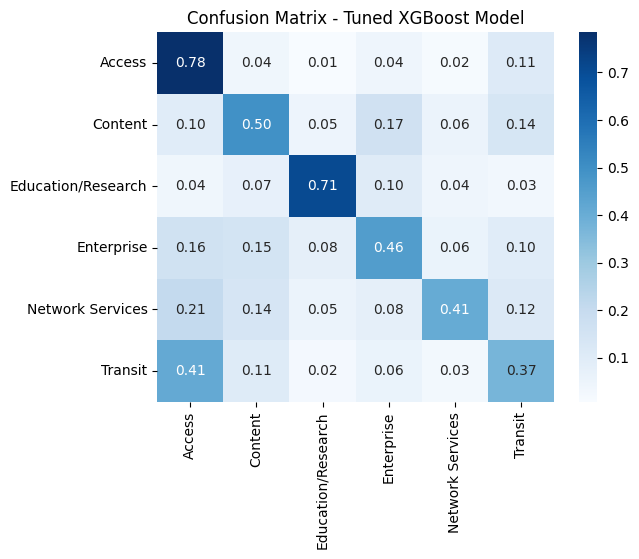

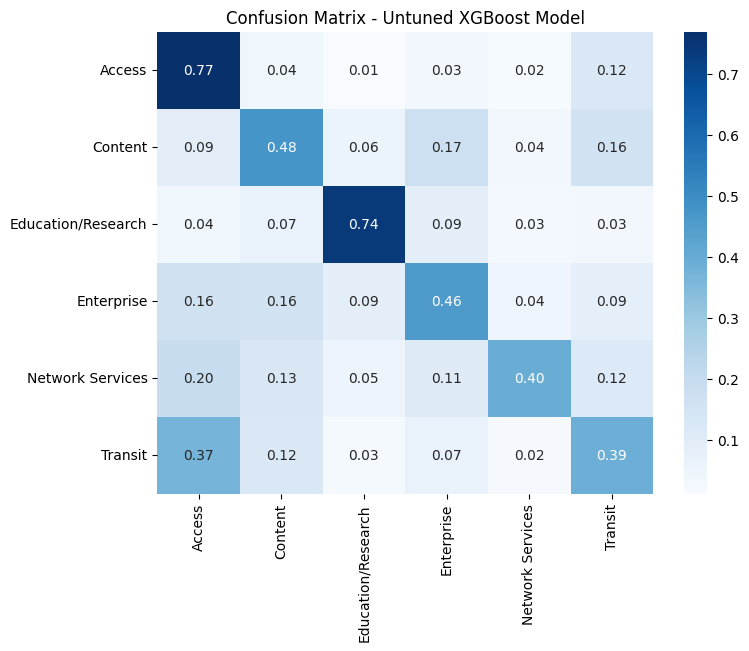

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, y_pred_sep, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)

plt.title("Confusion Matrix - Tuned XGBoost Model")
cm2 = confusion_matrix(y_te, y_pred, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(cm2, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Untuned XGBoost Model")
plt.show()

🔍 DETAILLIERTER MODELL-VERGLEICH


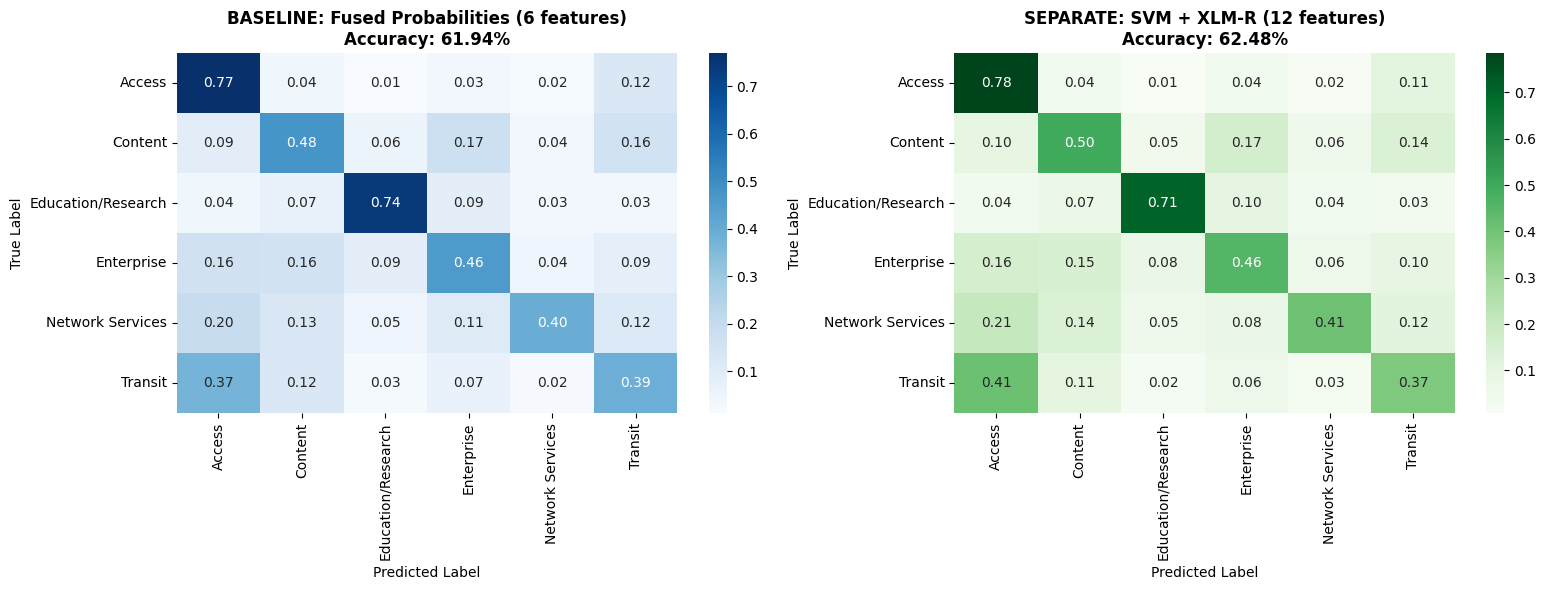


📊 PER-CLASS PERFORMANCE COMPARISON
Class                Metric          Fused Separate        Δ
----------------------------------------------------------------------
Access               Precision       0.791    0.782  -0.009 =
                     Recall          0.770    0.785   0.015 ↑
                     F1-Score        0.780    0.783   0.003 =
----------------------------------------------------------------------
Content              Precision       0.411    0.433   0.022 ↑
                     Recall          0.476    0.496   0.020 ↑
                     F1-Score        0.441    0.462   0.021 ↑
----------------------------------------------------------------------
Education/Research   Precision       0.605    0.640   0.035 ↑
                     Recall          0.738    0.708  -0.030 ↓
                     F1-Score        0.665    0.672   0.007 =
----------------------------------------------------------------------
Enterprise           Precision       0.451    0.445  -0.006 =

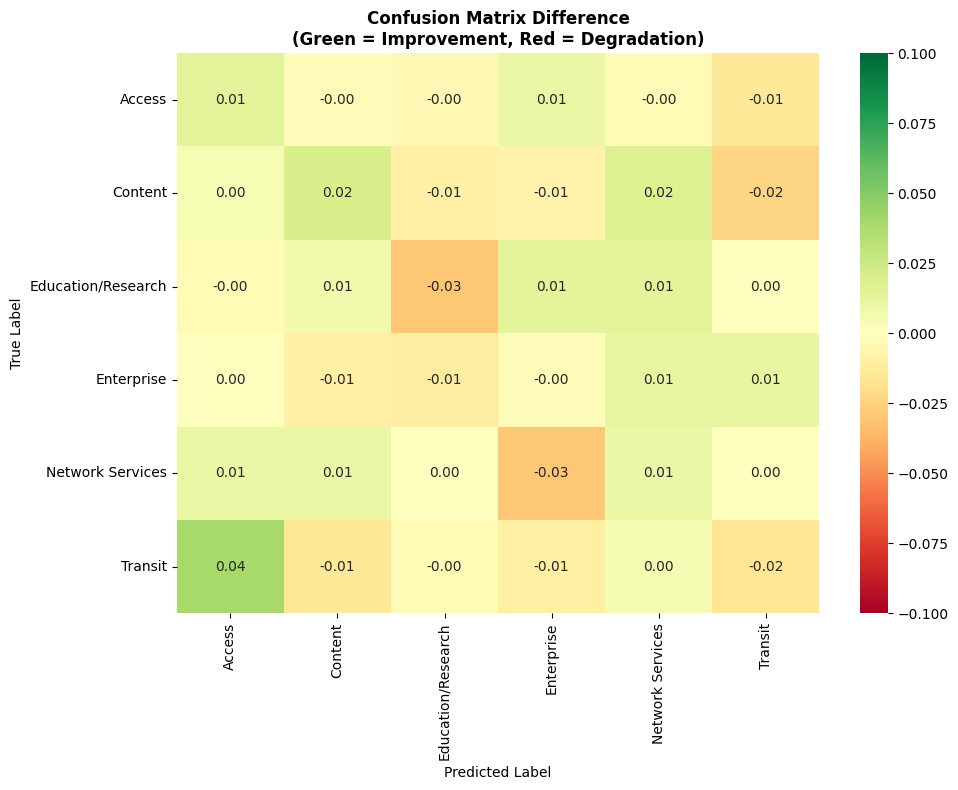

In [ ]:
# ============================================================
# Detaillierter Vergleich: Baseline vs Separate Probabilities
# ============================================================
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions von beiden Modellen
y_pred_fused = xgb.predict(X_ef_te_df)  # Baseline mit fused probabilities
y_pred_separate = xgb_sep.predict(X_sep_te_df)  # Separate probabilities

print("="*70)
print("🔍 DETAILLIERTER MODELL-VERGLEICH")
print("="*70)

# Side-by-side Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm_fused = confusion_matrix(y_te, y_pred_fused, normalize="true")
cm_separate = confusion_matrix(y_te, y_pred_separate, normalize="true")

sns.heatmap(cm_fused, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names, ax=ax1)
ax1.set_title("BASELINE: Fused Probabilities (6 features)\nAccuracy: {:.2%}".format(
    accuracy_score(y_te, y_pred_fused)), fontweight='bold', fontsize=12)
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

sns.heatmap(cm_separate, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=label_names, yticklabels=label_names, ax=ax2)
ax2.set_title("SEPARATE: SVM + XLM-R (12 features)\nAccuracy: {:.2%}".format(
    accuracy_score(y_te, y_pred_separate)), fontweight='bold', fontsize=12)
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()

# Per-Class Metrics Comparison
from sklearn.metrics import precision_recall_fscore_support

prec_f, rec_f, f1_f, supp = precision_recall_fscore_support(y_te, y_pred_fused, labels=range(len(label_names)))
prec_s, rec_s, f1_s, _ = precision_recall_fscore_support(y_te, y_pred_separate, labels=range(len(label_names)))

print("\n" + "="*70)
print("📊 PER-CLASS PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Class':<20} {'Metric':<12} {'Fused':>8} {'Separate':>8} {'Δ':>8}")
print("-"*70)

for i, class_name in enumerate(label_names):
    # Precision
    delta_p = prec_s[i] - prec_f[i]
    arrow_p = "↑" if delta_p > 0.01 else "↓" if delta_p < -0.01 else "="
    print(f"{class_name:<20} {'Precision':<12} {prec_f[i]:>8.3f} {prec_s[i]:>8.3f} {delta_p:>7.3f} {arrow_p}")
    
    # Recall
    delta_r = rec_s[i] - rec_f[i]
    arrow_r = "↑" if delta_r > 0.01 else "↓" if delta_r < -0.01 else "="
    print(f"{'':<20} {'Recall':<12} {rec_f[i]:>8.3f} {rec_s[i]:>8.3f} {delta_r:>7.3f} {arrow_r}")
    
    # F1
    delta_f1 = f1_s[i] - f1_f[i]
    arrow_f1 = "↑" if delta_f1 > 0.01 else "↓" if delta_f1 < -0.01 else "="
    print(f"{'':<20} {'F1-Score':<12} {f1_f[i]:>8.3f} {f1_s[i]:>8.3f} {delta_f1:>7.3f} {arrow_f1}")
    print("-"*70)

# Overall Metrics
acc_fused = accuracy_score(y_te, y_pred_fused)
acc_sep = accuracy_score(y_te, y_pred_separate)
f1_fused = f1_score(y_te, y_pred_fused, average='macro')
f1_sep = f1_score(y_te, y_pred_separate, average='macro')

print(f"\n{'OVERALL':<20} {'Accuracy':<12} {acc_fused:>8.3f} {acc_sep:>8.3f} {acc_sep-acc_fused:>7.3f}")
print(f"{'':<20} {'Macro F1':<12} {f1_fused:>8.3f} {f1_sep:>8.3f} {f1_sep-f1_fused:>7.3f}")
print("="*70)

# Confusion Matrix Difference
print("\n" + "="*70)
print("📉 CONFUSION MATRIX DIFFERENCE (Separate - Fused)")
print("   Positive values = better recall for that class")
print("="*70)

cm_diff = cm_separate - cm_fused
plt.figure(figsize=(10, 8))
sns.heatmap(cm_diff, annot=True, fmt=".2f", cmap="RdYlGn", center=0, 
            xticklabels=label_names, yticklabels=label_names, 
            vmin=-0.1, vmax=0.1)
plt.title("Confusion Matrix Difference\n(Green = Improvement, Red = Degradation)", 
          fontweight='bold', fontsize=12)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Erstelle separate Text-Features: SVM + XLM-R getrennt
# ============================================================

print("="*70)
print("🔧 Building features with SEPARATE text model probabilities")
print("="*70)

# We need to compute SVM and XLM-R probabilities separately for X_trB_text and X_te_text
# For SVM: Use svm_pipe (includes TF-IDF vectorization)
# For XLM-R: Use model directly with tokenizer

# Helper function to get XLM-R probabilities
def xlmr_proba_for_texts(texts, batch_size=64, max_length=256):
    """Get XLM-R probabilities for given texts"""
    import torch
    from tqdm import tqdm
    
    model.eval()
    all_probs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="XLM-R inference"):
            batch = texts[i:i+batch_size]
            enc = tok(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
    
    return np.vstack(all_probs)

# Compute probabilities for train (X_trB_text) 
print("\n🔄 Computing SVM probabilities for training data...")
# svm_pipe includes TF-IDF vectorization and calibrated SVM
P_svm_trB = svm_pipe.predict_proba(X_trB_text)

print("🔄 Computing XLM-R probabilities for training data...")  
P_xlmr_trB = xlmr_proba_for_texts(X_trB_text, batch_size=64, max_length=MAX_LENGTH)

# Compute probabilities for test (X_te_text)
print("🔄 Computing SVM probabilities for test data...")
P_svm_te_new = svm_pipe.predict_proba(X_te_text)

print("🔄 Computing XLM-R probabilities for test data...")
P_xlmr_te_new = xlmr_proba_for_texts(X_te_text, batch_size=64, max_length=MAX_LENGTH)

# Train: [Numeric Features | SVM Probs (6) | XLM-R Probs (6)]
X_sep_tr = np.hstack([Xnum_trB_pre, P_svm_trB, P_xlmr_trB])

# Test: [Numeric Features | SVM Probs (6) | XLM-R Probs (6)]
X_sep_te = np.hstack([Xnum_te_pre, P_svm_te_new, P_xlmr_te_new])

# Feature names
text_feature_names_svm = [f"SVM_P({label_names[i]})" for i in range(C)]
text_feature_names_xlmr = [f"XLM-R_P({label_names[i]})" for i in range(C)]
feature_names_sep = num_feature_names + text_feature_names_svm + text_feature_names_xlmr

print(f"\n📊 Feature Statistics:")
print(f"  Numeric Features:     {len(num_feature_names)}")
print(f"  SVM Probabilities:    {len(text_feature_names_svm)}")
print(f"  XLM-R Probabilities:  {len(text_feature_names_xlmr)}")
print(f"  Total Features:       {len(feature_names_sep)}")
print(f"\n  Original (fused):     {len(feature_names)} features")
print(f"  Improvement:          +{len(feature_names_sep) - len(feature_names)} features")

# Convert to DataFrame
X_sep_tr_df = pd.DataFrame(X_sep_tr, columns=feature_names_sep).astype(float)
X_sep_te_df = pd.DataFrame(X_sep_te, columns=feature_names_sep).astype(float)

print(f"\n✅ Feature matrices created successfully")
print(f"  Train shape: {X_sep_tr.shape}")
print(f"  Test shape:  {X_sep_te.shape}")
print("="*70)

🔧 Building features with SEPARATE text model probabilities

🔄 Computing SVM probabilities for training data...
🔄 Computing XLM-R probabilities for training data...


XLM-R inference: 100%|██████████| 94/94 [00:01<00:00, 90.78it/s]



🔄 Computing SVM probabilities for test data...
🔄 Computing XLM-R probabilities for test data...


XLM-R inference: 100%|██████████| 78/78 [00:00<00:00, 90.43it/s]


📊 Feature Statistics:
  Numeric Features:     129
  SVM Probabilities:    6
  XLM-R Probabilities:  6
  Total Features:       141

  Original (fused):     135 features
  Improvement:          +6 features

✅ Feature matrices created successfully
  Train shape: (5960, 141)
  Test shape:  (4966, 141)


## 🚀 Verbesserung 4: Separate Text-Modell Probabilities

**Problem:** Aktuell werden SVM + XLM-R zu einer Probability fusioniert (6 Features)  
**Lösung:** Gib XGBoost beide Modelle separat (12 Features statt 6)

**Warum das besser ist:**
- XGBoost kann Disagreement zwischen Modellen lernen
- Mehr granulare Information für den Meta-Learner
- Jedes Text-Modell hat eigene Stärken bei verschiedenen Klassen

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    """Optuna objective function für XGBoost Hyperparameter-Tuning"""
    
    # Hyperparameter-Suchraum
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_all)),
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        
        # Zu optimierende Parameter
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
    }
    
    # Train model
    model = XGBClassifier(**params)
    model.fit(
        X_ef_tr_df, y_trB,
        sample_weight=sample_weight,
        eval_set=[(X_ef_te_df, y_te)],
        verbose=0
    )
    
    # Evaluate on test set
    y_pred = model.predict(X_ef_te_df)
    
    # Optimize for macro-F1 (besser für unbalanced datasets)
    macro_f1 = f1_score(y_te, y_pred, average='macro')
    
    return macro_f1

print("="*70)
print("🔍 Starting Hyperparameter Optimization with Optuna")
print("="*70)
print(f"Search Space:")
print(f"  - n_estimators: [300, 1500]")
print(f"  - learning_rate: [0.01, 0.2]")
print(f"  - max_depth: [3, 10]")
print(f"  - subsample: [0.6, 1.0]")
print(f"  - colsample_bytree: [0.6, 1.0]")
print(f"  - reg_lambda: [0.1, 10.0]")
print(f"  - reg_alpha: [0.0, 5.0]")
print(f"  - min_child_weight: [1, 10]")
print(f"  - gamma: [0.0, 5.0]")
print(f"\nOptimization metric: Macro F1-Score")
print(f"Number of trials: 50")
print("="*70 + "\n")

# Create study
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

# Run optimization
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("✅ OPTIMIZATION COMPLETE")
print("="*70)
print(f"Best Macro F1-Score: {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print("="*70)

[I 2025-11-04 17:52:03,762] A new study created in memory with name: no-name-ed4aeeb3-cbe8-4dce-9dfd-4f28bb0b7b1e


🔍 Starting Hyperparameter Optimization with Optuna
Search Space:
  - n_estimators: [300, 1500]
  - learning_rate: [0.01, 0.2]
  - max_depth: [3, 10]
  - subsample: [0.6, 1.0]
  - colsample_bytree: [0.6, 1.0]
  - reg_lambda: [0.1, 10.0]
  - reg_alpha: [0.0, 5.0]
  - min_child_weight: [1, 10]
  - gamma: [0.0, 5.0]

Optimization metric: Macro F1-Score
Number of trials: 50



  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.533842:   2%|▏         | 1/50 [00:01<01:13,  1.51s/it]

[I 2025-11-04 17:52:05,269] Trial 0 finished with value: 0.5338419642271897 and parameters: {'n_estimators': 749, 'learning_rate': 0.17254716573280354, 'max_depth': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_lambda': 0.2051110418843398, 'reg_alpha': 0.2904180608409973, 'min_child_weight': 9, 'gamma': 3.005575058716044}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 0. Best value: 0.533842:   4%|▍         | 2/50 [00:14<06:41,  8.36s/it]

[I 2025-11-04 17:52:18,420] Trial 1 finished with value: 0.5277485942209107 and parameters: {'n_estimators': 1150, 'learning_rate': 0.010636066512540286, 'max_depth': 10, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_lambda': 0.23102018878452935, 'reg_alpha': 0.9170225492671691, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 0. Best value: 0.533842:   6%|▌         | 3/50 [00:23<06:32,  8.36s/it]

[I 2025-11-04 17:52:26,782] Trial 2 finished with value: 0.5319069657502654 and parameters: {'n_estimators': 818, 'learning_rate': 0.023927528765580644, 'max_depth': 7, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'reg_lambda': 0.5404103854647329, 'reg_alpha': 2.28034992108518, 'min_child_weight': 8, 'gamma': 0.9983689107917987}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 0. Best value: 0.533842:   8%|▊         | 4/50 [00:26<04:50,  6.31s/it]

[I 2025-11-04 17:52:29,961] Trial 3 finished with value: 0.5165514924987702 and parameters: {'n_estimators': 917, 'learning_rate': 0.05898602410432694, 'max_depth': 3, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'reg_lambda': 0.1349283426801325, 'reg_alpha': 4.7444276862666666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 0. Best value: 0.533842:  10%|█         | 5/50 [00:36<05:45,  7.67s/it]

[I 2025-11-04 17:52:40,037] Trial 4 finished with value: 0.5309251511176151 and parameters: {'n_estimators': 665, 'learning_rate': 0.013399060561509796, 'max_depth': 8, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'reg_lambda': 0.978033701665941, 'reg_alpha': 0.17194260557609198, 'min_child_weight': 10, 'gamma': 1.2938999080000846}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 0. Best value: 0.533842:  12%|█▏        | 6/50 [00:42<05:16,  7.20s/it]

[I 2025-11-04 17:52:46,330] Trial 5 finished with value: 0.5233591870472686 and parameters: {'n_estimators': 1095, 'learning_rate': 0.02544166090938368, 'max_depth': 7, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'reg_lambda': 8.692991511139551, 'reg_alpha': 3.8756641168055728, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 0. Best value: 0.533842:  14%|█▍        | 7/50 [00:44<03:51,  5.38s/it]

[I 2025-11-04 17:52:47,965] Trial 6 finished with value: 0.5223448488115524 and parameters: {'n_estimators': 1018, 'learning_rate': 0.15826541904647565, 'max_depth': 3, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'reg_lambda': 0.4473636174621265, 'reg_alpha': 1.9433864484474102, 'min_child_weight': 3, 'gamma': 4.143687545759647}. Best is trial 0 with value: 0.5338419642271897.


Best trial: 7. Best value: 0.536493:  16%|█▌        | 8/50 [00:53<04:31,  6.47s/it]

[I 2025-11-04 17:52:56,776] Trial 7 finished with value: 0.5364932584064946 and parameters: {'n_estimators': 728, 'learning_rate': 0.023200867504756827, 'max_depth': 7, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_lambda': 0.14096175149815865, 'reg_alpha': 4.9344346830025865, 'min_child_weight': 8, 'gamma': 0.993578407670862}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  18%|█▊        | 9/50 [00:54<03:19,  4.87s/it]

[I 2025-11-04 17:52:58,123] Trial 8 finished with value: 0.5202480278727535 and parameters: {'n_estimators': 306, 'learning_rate': 0.11506408247250169, 'max_depth': 8, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_lambda': 0.14063366777718173, 'reg_alpha': 1.7923286427213632, 'min_child_weight': 2, 'gamma': 4.315517129377968}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  20%|██        | 10/50 [01:00<03:33,  5.34s/it]

[I 2025-11-04 17:53:04,522] Trial 9 finished with value: 0.5219120152716474 and parameters: {'n_estimators': 1048, 'learning_rate': 0.026946865572417687, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'reg_lambda': 2.878805718308924, 'reg_alpha': 3.1877873567760657, 'min_child_weight': 9, 'gamma': 2.3610746258097466}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  22%|██▏       | 11/50 [01:05<03:17,  5.05s/it]

[I 2025-11-04 17:53:08,923] Trial 10 finished with value: 0.5279514833202702 and parameters: {'n_estimators': 1435, 'learning_rate': 0.06254517730997454, 'max_depth': 5, 'subsample': 0.6071847502459279, 'colsample_bytree': 0.9924283304357215, 'reg_lambda': 2.4015639024822484, 'reg_alpha': 4.865188803848123, 'min_child_weight': 6, 'gamma': 0.1989980303850739}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  24%|██▍       | 12/50 [01:07<02:36,  4.12s/it]

[I 2025-11-04 17:53:10,905] Trial 11 finished with value: 0.5208214650867511 and parameters: {'n_estimators': 578, 'learning_rate': 0.09892433069725924, 'max_depth': 10, 'subsample': 0.7569254896555033, 'colsample_bytree': 0.8250122810664506, 'reg_lambda': 0.2971932978338389, 'reg_alpha': 3.532974466122918, 'min_child_weight': 7, 'gamma': 2.8492529495395877}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  26%|██▌       | 13/50 [01:11<02:34,  4.18s/it]

[I 2025-11-04 17:53:15,230] Trial 12 finished with value: 0.5248154867690057 and parameters: {'n_estimators': 532, 'learning_rate': 0.03491899555663909, 'max_depth': 5, 'subsample': 0.9982632308542216, 'colsample_bytree': 0.8436295453734979, 'reg_lambda': 0.12430309738412394, 'reg_alpha': 1.0414013305441192, 'min_child_weight': 7, 'gamma': 1.6792167927578805}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  28%|██▊       | 14/50 [01:12<01:56,  3.23s/it]

[I 2025-11-04 17:53:16,245] Trial 13 finished with value: 0.5180123223861139 and parameters: {'n_estimators': 711, 'learning_rate': 0.1893571899699074, 'max_depth': 9, 'subsample': 0.8923645209213664, 'colsample_bytree': 0.9073381428562668, 'reg_lambda': 0.261713497807315, 'reg_alpha': 0.1792505114990261, 'min_child_weight': 5, 'gamma': 3.2848896661335685}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  30%|███       | 15/50 [01:17<02:14,  3.86s/it]

[I 2025-11-04 17:53:21,562] Trial 14 finished with value: 0.5308774503395742 and parameters: {'n_estimators': 438, 'learning_rate': 0.015369369624069039, 'max_depth': 6, 'subsample': 0.692612210972885, 'colsample_bytree': 0.7653656398770852, 'reg_lambda': 0.862299611668763, 'reg_alpha': 2.88391634718279, 'min_child_weight': 8, 'gamma': 0.4536455695490411}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  32%|███▏      | 16/50 [01:21<02:09,  3.81s/it]

[I 2025-11-04 17:53:25,260] Trial 15 finished with value: 0.5244091302314174 and parameters: {'n_estimators': 811, 'learning_rate': 0.0567587490088489, 'max_depth': 8, 'subsample': 0.6043956756975085, 'colsample_bytree': 0.9780771730489877, 'reg_lambda': 2.0336091559887834, 'reg_alpha': 4.157172402801631, 'min_child_weight': 8, 'gamma': 3.382668099091836}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  34%|███▍      | 17/50 [01:23<01:47,  3.25s/it]

[I 2025-11-04 17:53:27,228] Trial 16 finished with value: 0.5275458477253133 and parameters: {'n_estimators': 1283, 'learning_rate': 0.09784261700490905, 'max_depth': 6, 'subsample': 0.8503991699305873, 'colsample_bytree': 0.881717297919253, 'reg_lambda': 0.10687867561724579, 'reg_alpha': 1.2877800957844054, 'min_child_weight': 6, 'gamma': 2.030755337592751}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  36%|███▌      | 18/50 [01:27<01:47,  3.35s/it]

[I 2025-11-04 17:53:30,800] Trial 17 finished with value: 0.5296982692443871 and parameters: {'n_estimators': 886, 'learning_rate': 0.04048254122635745, 'max_depth': 9, 'subsample': 0.7490914921434734, 'colsample_bytree': 0.7723754461877381, 'reg_lambda': 0.45183635887455054, 'reg_alpha': 2.6207137690143676, 'min_child_weight': 1, 'gamma': 4.955492967071801}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  38%|███▊      | 19/50 [01:33<02:13,  4.31s/it]

[I 2025-11-04 17:53:37,340] Trial 18 finished with value: 0.5259012005221336 and parameters: {'n_estimators': 654, 'learning_rate': 0.016766084909031174, 'max_depth': 5, 'subsample': 0.7877385071054385, 'colsample_bytree': 0.943909336678787, 'reg_lambda': 0.20696771271195472, 'reg_alpha': 4.093784190410645, 'min_child_weight': 9, 'gamma': 0.8219836880499272}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  40%|████      | 20/50 [01:39<02:20,  4.67s/it]

[I 2025-11-04 17:53:42,849] Trial 19 finished with value: 0.5268064003533007 and parameters: {'n_estimators': 461, 'learning_rate': 0.03116661050547902, 'max_depth': 9, 'subsample': 0.9462037175174185, 'colsample_bytree': 0.8554760218688221, 'reg_lambda': 0.6508454832718199, 'reg_alpha': 0.7192778483990514, 'min_child_weight': 7, 'gamma': 1.6689794339334254}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  42%|████▏     | 21/50 [01:46<02:37,  5.42s/it]

[I 2025-11-04 17:53:50,025] Trial 20 finished with value: 0.5297120549902511 and parameters: {'n_estimators': 730, 'learning_rate': 0.02076861867376838, 'max_depth': 7, 'subsample': 0.7121904483640666, 'colsample_bytree': 0.6060084846502749, 'reg_lambda': 0.1772046392353248, 'reg_alpha': 1.5972733117451905, 'min_child_weight': 9, 'gamma': 3.3785413081153264}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  44%|████▍     | 22/50 [01:55<03:05,  6.62s/it]

[I 2025-11-04 17:53:59,433] Trial 21 finished with value: 0.5331105192813336 and parameters: {'n_estimators': 855, 'learning_rate': 0.021827837471917657, 'max_depth': 7, 'subsample': 0.656121463619621, 'colsample_bytree': 0.7130366546802294, 'reg_lambda': 0.38626586499063603, 'reg_alpha': 2.31535683191441, 'min_child_weight': 8, 'gamma': 1.0375453593473738}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  46%|████▌     | 23/50 [02:06<03:33,  7.90s/it]

[I 2025-11-04 17:54:10,319] Trial 22 finished with value: 0.5316911983503725 and parameters: {'n_estimators': 922, 'learning_rate': 0.018589594455292163, 'max_depth': 6, 'subsample': 0.6387129069568872, 'colsample_bytree': 0.7217854989503741, 'reg_lambda': 0.3483687437951344, 'reg_alpha': 2.327122497128112, 'min_child_weight': 8, 'gamma': 0.6608413857851261}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  48%|████▊     | 24/50 [02:11<03:02,  7.01s/it]

[I 2025-11-04 17:54:15,239] Trial 23 finished with value: 0.531105451402423 and parameters: {'n_estimators': 804, 'learning_rate': 0.04788230312731283, 'max_depth': 8, 'subsample': 0.649818846561549, 'colsample_bytree': 0.7972156654172277, 'reg_lambda': 1.4812259174136906, 'reg_alpha': 3.157648086110802, 'min_child_weight': 5, 'gamma': 1.2692040800808921}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  50%|█████     | 25/50 [02:19<03:03,  7.34s/it]

[I 2025-11-04 17:54:23,367] Trial 24 finished with value: 0.530289348934612 and parameters: {'n_estimators': 582, 'learning_rate': 0.01060204504957224, 'max_depth': 7, 'subsample': 0.8106550849823198, 'colsample_bytree': 0.7520019025427916, 'reg_lambda': 0.17633061372530395, 'reg_alpha': 0.583261084148299, 'min_child_weight': 9, 'gamma': 2.0389971723176883}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  52%|█████▏    | 26/50 [02:23<02:29,  6.21s/it]

[I 2025-11-04 17:54:26,950] Trial 25 finished with value: 0.523473399994986 and parameters: {'n_estimators': 978, 'learning_rate': 0.07907308435862881, 'max_depth': 8, 'subsample': 0.7405114480881256, 'colsample_bytree': 0.6325936334827382, 'reg_lambda': 0.10022826965470302, 'reg_alpha': 4.397453007596632, 'min_child_weight': 7, 'gamma': 0.012530207227537837}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  54%|█████▍    | 27/50 [02:27<02:09,  5.62s/it]

[I 2025-11-04 17:54:31,198] Trial 26 finished with value: 0.5334478976064357 and parameters: {'n_estimators': 763, 'learning_rate': 0.03650417109223905, 'max_depth': 6, 'subsample': 0.6843342524748096, 'colsample_bytree': 0.6907939095057634, 'reg_lambda': 0.3250206082442993, 'reg_alpha': 1.3636750995157252, 'min_child_weight': 6, 'gamma': 3.0235697064340226}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  56%|█████▌    | 28/50 [02:32<02:01,  5.52s/it]

[I 2025-11-04 17:54:36,487] Trial 27 finished with value: 0.5219678401947051 and parameters: {'n_estimators': 755, 'learning_rate': 0.03987302678652715, 'max_depth': 4, 'subsample': 0.6854988550485904, 'colsample_bytree': 0.6952570329718042, 'reg_lambda': 0.2694086690872815, 'reg_alpha': 1.3932386137732924, 'min_child_weight': 6, 'gamma': 2.9878529810933356}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  58%|█████▊    | 29/50 [02:36<01:47,  5.11s/it]

[I 2025-11-04 17:54:40,621] Trial 28 finished with value: 0.5313214817450326 and parameters: {'n_estimators': 372, 'learning_rate': 0.029677912232698517, 'max_depth': 6, 'subsample': 0.8621152901246624, 'colsample_bytree': 0.649391534794159, 'reg_lambda': 0.6623456937768787, 'reg_alpha': 0.35973077454934055, 'min_child_weight': 4, 'gamma': 2.3316958241532935}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  60%|██████    | 30/50 [02:48<02:20,  7.02s/it]

[I 2025-11-04 17:54:52,113] Trial 29 finished with value: 0.5325506470165268 and parameters: {'n_estimators': 1234, 'learning_rate': 0.013065080211684189, 'max_depth': 9, 'subsample': 0.7066914875675219, 'colsample_bytree': 0.9648137867527937, 'reg_lambda': 0.2046105342223658, 'reg_alpha': 0.9215403145212702, 'min_child_weight': 4, 'gamma': 3.726896919246168}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  62%|██████▏   | 31/50 [02:49<01:42,  5.39s/it]

[I 2025-11-04 17:54:53,702] Trial 30 finished with value: 0.523942709893107 and parameters: {'n_estimators': 636, 'learning_rate': 0.13093051319481788, 'max_depth': 10, 'subsample': 0.622029583553521, 'colsample_bytree': 0.805068165651217, 'reg_lambda': 4.370471489831402, 'reg_alpha': 0.009003108336354815, 'min_child_weight': 5, 'gamma': 2.711856091138316}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  64%|██████▍   | 32/50 [02:58<01:55,  6.42s/it]

[I 2025-11-04 17:55:02,536] Trial 31 finished with value: 0.5351490929250268 and parameters: {'n_estimators': 866, 'learning_rate': 0.021416600626172056, 'max_depth': 7, 'subsample': 0.666368247166107, 'colsample_bytree': 0.6825869887785095, 'reg_lambda': 0.38032553628456467, 'reg_alpha': 1.9847530496571744, 'min_child_weight': 8, 'gamma': 1.4912259468230156}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  66%|██████▌   | 33/50 [03:04<01:43,  6.07s/it]

[I 2025-11-04 17:55:07,784] Trial 32 finished with value: 0.5316267922598951 and parameters: {'n_estimators': 787, 'learning_rate': 0.03535604309457301, 'max_depth': 7, 'subsample': 0.666411206561106, 'colsample_bytree': 0.6905527669563061, 'reg_lambda': 0.1623510713769141, 'reg_alpha': 1.981147531370931, 'min_child_weight': 9, 'gamma': 3.063153367003832}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  68%|██████▊   | 34/50 [03:07<01:26,  5.43s/it]

[I 2025-11-04 17:55:11,706] Trial 33 finished with value: 0.531587064617317 and parameters: {'n_estimators': 921, 'learning_rate': 0.04580609275182053, 'max_depth': 6, 'subsample': 0.6315205849616494, 'colsample_bytree': 0.6582871483966586, 'reg_lambda': 0.3172742637840962, 'reg_alpha': 1.4305254059875518, 'min_child_weight': 8, 'gamma': 1.8050523630493975}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  70%|███████   | 35/50 [03:13<01:22,  5.49s/it]

[I 2025-11-04 17:55:17,355] Trial 34 finished with value: 0.5225612558117474 and parameters: {'n_estimators': 696, 'learning_rate': 0.024022647294179942, 'max_depth': 5, 'subsample': 0.8287148939409164, 'colsample_bytree': 0.7481566382084014, 'reg_lambda': 0.5578511521928167, 'reg_alpha': 1.039024101320107, 'min_child_weight': 10, 'gamma': 3.7616397439470317}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  72%|███████▏  | 36/50 [03:27<01:51,  7.95s/it]

[I 2025-11-04 17:55:31,052] Trial 35 finished with value: 0.5297694268710442 and parameters: {'n_estimators': 963, 'learning_rate': 0.012906258331558663, 'max_depth': 8, 'subsample': 0.7667841778636113, 'colsample_bytree': 0.6866908733809229, 'reg_lambda': 0.25568397209512145, 'reg_alpha': 2.6211576673290553, 'min_child_weight': 7, 'gamma': 1.3725856958428546}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  74%|███████▍  | 37/50 [03:36<01:46,  8.20s/it]

[I 2025-11-04 17:55:39,824] Trial 36 finished with value: 0.5339541569453641 and parameters: {'n_estimators': 851, 'learning_rate': 0.0195020799115287, 'max_depth': 7, 'subsample': 0.7251402137971191, 'colsample_bytree': 0.6309394136016218, 'reg_lambda': 1.269853358734664, 'reg_alpha': 2.0871249058671317, 'min_child_weight': 10, 'gamma': 2.5060182756870795}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  76%|███████▌  | 38/50 [03:46<01:46,  8.87s/it]

[I 2025-11-04 17:55:50,266] Trial 37 finished with value: 0.5318379669014409 and parameters: {'n_estimators': 1193, 'learning_rate': 0.018870318093430115, 'max_depth': 8, 'subsample': 0.7282977034916853, 'colsample_bytree': 0.6278322006043399, 'reg_lambda': 1.18579467968548, 'reg_alpha': 1.979435315858737, 'min_child_weight': 10, 'gamma': 2.605915395910267}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  78%|███████▊  | 39/50 [03:56<01:40,  9.18s/it]

[I 2025-11-04 17:56:00,159] Trial 38 finished with value: 0.5270552423664031 and parameters: {'n_estimators': 858, 'learning_rate': 0.015069167611154597, 'max_depth': 7, 'subsample': 0.7817108221233882, 'colsample_bytree': 0.6399599767500141, 'reg_lambda': 1.4604896354108188, 'reg_alpha': 3.543531723855473, 'min_child_weight': 10, 'gamma': 2.0387147419967944}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  80%|████████  | 40/50 [04:03<01:24,  8.48s/it]

[I 2025-11-04 17:56:06,996] Trial 39 finished with value: 0.5281225938547127 and parameters: {'n_estimators': 1028, 'learning_rate': 0.027719415652370953, 'max_depth': 7, 'subsample': 0.8944628155247061, 'colsample_bytree': 0.6122138817275093, 'reg_lambda': 4.307988588380652, 'reg_alpha': 4.631420483141734, 'min_child_weight': 9, 'gamma': 1.392476198041713}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  82%|████████▏ | 41/50 [04:10<01:13,  8.21s/it]

[I 2025-11-04 17:56:14,588] Trial 40 finished with value: 0.5286331337668917 and parameters: {'n_estimators': 1124, 'learning_rate': 0.02214000005965247, 'max_depth': 9, 'subsample': 0.7967436858195566, 'colsample_bytree': 0.6673173882775729, 'reg_lambda': 0.91594684180463, 'reg_alpha': 3.064597009771008, 'min_child_weight': 10, 'gamma': 2.4308437948518864}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  84%|████████▍ | 42/50 [04:16<00:58,  7.36s/it]

[I 2025-11-04 17:56:19,972] Trial 41 finished with value: 0.5247679875028622 and parameters: {'n_estimators': 621, 'learning_rate': 0.033705632120896376, 'max_depth': 6, 'subsample': 0.675030803427374, 'colsample_bytree': 0.6627347900135979, 'reg_lambda': 0.14148332666847643, 'reg_alpha': 1.6430381362646842, 'min_child_weight': 8, 'gamma': 3.121623306863811}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  86%|████████▌ | 43/50 [04:22<00:49,  7.07s/it]

[I 2025-11-04 17:56:26,370] Trial 42 finished with value: 0.5289032238964331 and parameters: {'n_estimators': 760, 'learning_rate': 0.025826951337368256, 'max_depth': 7, 'subsample': 0.7026124401016556, 'colsample_bytree': 0.7091759373852482, 'reg_lambda': 0.5320732200076144, 'reg_alpha': 2.007409681912513, 'min_child_weight': 9, 'gamma': 3.6731036022270187}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 7. Best value: 0.536493:  88%|████████▊ | 44/50 [04:26<00:36,  6.06s/it]

[I 2025-11-04 17:56:30,068] Trial 43 finished with value: 0.530211793769319 and parameters: {'n_estimators': 834, 'learning_rate': 0.05226850548870297, 'max_depth': 8, 'subsample': 0.6656625742475548, 'colsample_bytree': 0.6015809924449511, 'reg_lambda': 0.40586797473918784, 'reg_alpha': 0.5864926595283242, 'min_child_weight': 10, 'gamma': 2.2624206338520247}. Best is trial 7 with value: 0.5364932584064946.


Best trial: 44. Best value: 0.539546:  90%|█████████ | 45/50 [04:29<00:25,  5.16s/it]

[I 2025-11-04 17:56:33,130] Trial 44 finished with value: 0.5395460504098796 and parameters: {'n_estimators': 542, 'learning_rate': 0.0741472773579533, 'max_depth': 6, 'subsample': 0.7240904579805101, 'colsample_bytree': 0.6778570301910631, 'reg_lambda': 0.20843829219020332, 'reg_alpha': 2.201147858760482, 'min_child_weight': 3, 'gamma': 2.8427966201900747}. Best is trial 44 with value: 0.5395460504098796.


Best trial: 44. Best value: 0.539546:  92%|█████████▏| 46/50 [04:32<00:18,  4.54s/it]

[I 2025-11-04 17:56:36,221] Trial 45 finished with value: 0.5221544648265003 and parameters: {'n_estimators': 512, 'learning_rate': 0.07134653716214885, 'max_depth': 4, 'subsample': 0.7257827229557194, 'colsample_bytree': 0.7366395272306799, 'reg_lambda': 0.1271569930548727, 'reg_alpha': 3.4164660164514165, 'min_child_weight': 3, 'gamma': 2.825849350852691}. Best is trial 44 with value: 0.5395460504098796.


Best trial: 44. Best value: 0.539546:  94%|█████████▍| 47/50 [04:33<00:10,  3.56s/it]

[I 2025-11-04 17:56:37,482] Trial 46 finished with value: 0.5189009426707348 and parameters: {'n_estimators': 683, 'learning_rate': 0.1849851085862603, 'max_depth': 7, 'subsample': 0.8729800031659418, 'colsample_bytree': 0.9267671036211991, 'reg_lambda': 0.23102308925414616, 'reg_alpha': 2.8175248123431946, 'min_child_weight': 2, 'gamma': 1.0145387416156368}. Best is trial 44 with value: 0.5395460504098796.


Best trial: 44. Best value: 0.539546:  96%|█████████▌| 48/50 [04:35<00:05,  3.00s/it]

[I 2025-11-04 17:56:39,171] Trial 47 finished with value: 0.523511343294169 and parameters: {'n_estimators': 519, 'learning_rate': 0.13912323166193236, 'max_depth': 8, 'subsample': 0.8252523496757214, 'colsample_bytree': 0.6243120514043007, 'reg_lambda': 0.1580060240073931, 'reg_alpha': 2.2067679923136616, 'min_child_weight': 3, 'gamma': 1.7975610461970088}. Best is trial 44 with value: 0.5395460504098796.


Best trial: 44. Best value: 0.539546:  98%|█████████▊| 49/50 [04:37<00:02,  2.86s/it]

[I 2025-11-04 17:56:41,699] Trial 48 finished with value: 0.5290444559309835 and parameters: {'n_estimators': 1078, 'learning_rate': 0.10137186534005543, 'max_depth': 6, 'subsample': 0.6186458766901913, 'colsample_bytree': 0.8794153390979675, 'reg_lambda': 0.19461133021957655, 'reg_alpha': 2.1708745134972243, 'min_child_weight': 2, 'gamma': 0.5653141462664626}. Best is trial 44 with value: 0.5395460504098796.


Best trial: 44. Best value: 0.539546: 100%|██████████| 50/50 [04:40<00:00,  5.61s/it]

[I 2025-11-04 17:56:44,137] Trial 49 finished with value: 0.527491559853121 and parameters: {'n_estimators': 566, 'learning_rate': 0.07953346058160798, 'max_depth': 7, 'subsample': 0.7639040492681792, 'colsample_bytree': 0.6501080244338882, 'reg_lambda': 1.124373385049529, 'reg_alpha': 1.7405451941233716, 'min_child_weight': 1, 'gamma': 2.170524575040871}. Best is trial 44 with value: 0.5395460504098796.

✅ OPTIMIZATION COMPLETE
Best Macro F1-Score: 0.5395

Best Hyperparameters:
  n_estimators: 542
  learning_rate: 0.0741472773579533
  max_depth: 6
  subsample: 0.7240904579805101
  colsample_bytree: 0.6778570301910631
  reg_lambda: 0.20843829219020332
  reg_alpha: 2.201147858760482
  min_child_weight: 3
  gamma: 2.8427966201900747


## 🎯 Verbesserung 3: Hyperparameter-Tuning mit Optuna

**Idee:** Systematische Optimierung der XGBoost-Hyperparameter statt manuelles Tuning

**Vorher:** Manually gesetzte Parameter (learning_rate=0.05, max_depth=6, etc.)  
**Jetzt:** Optuna findet die optimale Kombination durch intelligente Suche

In [ ]:
# Install Optuna for hyperparameter optimization
%pip install optuna -q

## 🚀 Verbesserungsvorschlag 1: Probability Calibration

**Problem:** XGBoost-Probabilities sind oft nicht gut kalibriert
**Lösung:** Isotonic Regression auf den Probabilities

In [ ]:
import numpy as np
def check_nan(name, X):
    bad = ~np.isfinite(X).all()
    print(f"[{name}] finite={not bad}, shape={X.shape}")
    return bad

bad1 = check_nan("Xnum_trB_pre", Xnum_trB_pre)
bad2 = check_nan("P_text_trB",   P_text_trB)
bad3 = check_nan("Xnum_te_pre",  Xnum_te_pre)
bad4 = check_nan("P_text_te",    P_text_te)
# Wenn True: Quelle finden, z. B. mit np.where(~np.isfinite(...))


[Xnum_trB_pre] finite=False, shape=(5960, 129)
[P_text_trB] finite=True, shape=(5960, 6)
[Xnum_te_pre] finite=False, shape=(4966, 129)
[P_text_te] finite=True, shape=(4966, 6)


In [ ]:
# === CatBoost Early-Fusion (statt XGBoost) ===
from catboost import CatBoostClassifier, Pool
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Sicherheitsnetz: ±Inf -> NaN (CatBoost kann NaN, aber kein Inf)
def sanitize(X):
    X = np.array(X, dtype=float, copy=True)
    X[~np.isfinite(X)] = np.nan
    return X

X_ef_tr_s = sanitize(X_ef_tr)
X_ef_te_s = sanitize(X_ef_te)

# Class Weights wie zuvor
counts = Counter(y_trB)
max_count = max(counts.values())
sample_weight = np.array([max_count / counts[y] for y in y_trB], dtype=float)

train_pool = Pool(X_ef_tr_s, y_trB, weight=sample_weight)
valid_pool = Pool(X_ef_te_s, y_te)

cb = CatBoostClassifier(
    loss_function="MultiClass",
    learning_rate=0.05,
    depth=6,                 # 4–8 testen
    l2_leaf_reg=3.0,
    iterations=4000,         # groß + early stopping
    random_seed=42,
    od_type="Iter",          # Early Stopping
    od_wait=50,
    verbose=100
)

cb.fit(train_pool, eval_set=valid_pool)

# Test
y_pred = cb.predict(X_ef_te_s).astype(int).ravel()
y_prob = cb.predict_proba(X_ef_te_s)

print("Accuracy:", accuracy_score(y_te, y_pred))
print("Macro-F1:", f1_score(y_te, y_pred, average="macro"))
print(classification_report(y_te, y_pred, target_names=label_names if label_names else None))


ModuleNotFoundError: No module named 'catboost'